# Real Astronomical Spectroscopy with Astropy

This notebook uses **real astronomical data** from archives like SDSS, MAST, and ESO.

**Educational Context**: This notebook demonstrates both professional archive data analysis and principles applicable to low-cost undergraduate spectrometers (e.g., 600 lines/mm diffraction grating setups with CMOS sensors).

**First time setup**: Run the installation cell below to install required packages.

In [1]:
# Install required packages (run once)
# This may take a few minutes on first run

%pip install astropy specutils astroquery -q

print("✅ Installation complete! Restart kernel if needed.")

Note: you may need to restart the kernel to use updated packages.
✅ Installation complete! Restart kernel if needed.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setup and Imports

In [2]:
## Setup and Imports - Real Astronomical Data with Astropy

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import simpson
from datetime import datetime

# Astropy ecosystem for real astronomical data
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.nddata import StdDevUncertainty

# Specutils for spectral analysis
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import FluxConservingResampler, extract_region
from specutils.analysis import equivalent_width, line_flux
from specutils.fitting import fit_lines

# astroquery for querying astronomical databases
from astroquery.sdss import SDSS
from astroquery.mast import Observations
from astroquery.simbad import Simbad

print("✅ Imports successful")
print(f"   NumPy: {np.__version__}")
print(f"   Session: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("   Ready to query real astronomical spectra!")

✅ Imports successful
   NumPy: 2.1.3
   Session: 2025-12-26 14:12:51
   Ready to query real astronomical spectra!


## 1. Stellar Spectroscopy Data Handler

Based on your NMR `load_fid_and_preview` function, this class handles stellar spectral data.

In [3]:
class RealStellarSpectrumAnalyzer:
    """
    Real stellar spectrum analysis using Astropy ecosystem.
    
    Workflow:
    1. Query astronomical databases (SDSS, MAST, etc.) or load FITS files
    2. Use Specutils for spectral manipulation and analysis
    3. Extract spectral lines, measure equivalent widths, fit Gaussians
    4. Analyze real stellar properties from real data
    """
    
    def __init__(self, object_name=None):
        """
        Args:
            object_name: Name of astronomical object (e.g., 'Vega', 'M31', SDSS coordinates)
        """
        self.object_name = object_name
        self.spectrum = None  # Spectrum1D object
        self.wavelength = None
        self.flux = None
        self.coordinate = None
        
    def query_sdss_spectrum(self, ra, dec, radius=2*u.arcsec):
        """
        Query SDSS for spectroscopic data at given coordinates.
        
        Args:
            ra: Right Ascension (degrees or astropy Quantity)
            dec: Declination (degrees or astropy Quantity)
            radius: Search radius
            
        Returns:
            Spectrum1D object
        """
        coord = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg), frame='icrs')
        self.coordinate = coord
        
        print(f"🔍 Querying SDSS at RA={ra}, Dec={dec}...")
        
        # Query SDSS
        spec_data = SDSS.query_region(coord, radius=radius, spectro=True)
        
        if spec_data is None or len(spec_data) == 0:
            print("❌ No spectra found in SDSS")
            return None
            
        print(f"✅ Found {len(spec_data)} spectrum/spectra")
        
        # Get the first spectrum
        spec = SDSS.get_spectra(matches=spec_data[0:1])[0]
        
        # Extract wavelength and flux
        hdu = spec[1]
        wavelength = 10**hdu.data['loglam'] * u.Angstrom
        flux = hdu.data['flux'] * 1e-17 * u.erg / u.s / u.cm**2 / u.Angstrom
        
        # Create Spectrum1D object
        self.spectrum = Spectrum1D(spectral_axis=wavelength, flux=flux)
        self.wavelength = wavelength
        self.flux = flux
        
        print(f"   Wavelength range: {wavelength.min():.2f} - {wavelength.max():.2f}")
        print(f"   Data points: {len(wavelength)}")
        
        return self.spectrum
    
    def load_fits_spectrum(self, filepath):
        """
        Load spectrum from a FITS file.
        
        Args:
            filepath: Path to FITS file
            
        Returns:
            Spectrum1D object
        """
        print(f"📂 Loading FITS file: {filepath}")
        
        # Load with Specutils (it handles various FITS formats)
        self.spectrum = Spectrum1D.read(filepath)
        self.wavelength = self.spectrum.spectral_axis
        self.flux = self.spectrum.flux
        
        print(f"✅ Loaded spectrum")
        print(f"   Wavelength range: {self.wavelength.min():.2f} - {self.wavelength.max():.2f}")
        print(f"   Data points: {len(self.wavelength)}")
        
        return self.spectrum
    
    def query_object_by_name(self, object_name):
        """
        Query SIMBAD for object coordinates, then search for spectra.
        
        Args:
            object_name: Common name (e.g., 'Vega', 'Betelgeuse', 'M31')
        """
        self.object_name = object_name
        
        print(f"🔍 Looking up '{object_name}' in SIMBAD...")
        
        # Query SIMBAD
        result = Simbad.query_object(object_name)
        
        if result is None:
            print(f"❌ Object '{object_name}' not found in SIMBAD")
            return None
            
        ra = result['RA'][0]
        dec = result['DEC'][0]
        
        coord = SkyCoord(ra, dec, unit=(u.hourangle, u.deg), frame='icrs')
        self.coordinate = coord
        
        print(f"✅ Found {object_name}")
        print(f"   RA: {coord.ra.deg:.4f}°, Dec: {coord.dec.deg:.4f}°")
        
        # Try to get SDSS spectrum
        return self.query_sdss_spectrum(coord.ra.deg, coord.dec.deg)
    
    def plot_spectrum(self, xlim=None, show_lines=True):
        """
        Plot the spectrum with optional spectral line markers.
        
        Args:
            xlim: Wavelength range tuple (min, max) in Angstroms
            show_lines: Whether to mark common spectral lines
        """
        if self.spectrum is None:
            print("❌ No spectrum loaded")
            return
            
        fig, ax = plt.subplots(figsize=(14, 5))
        
        # Plot spectrum
        ax.plot(self.wavelength, self.flux, 'k-', linewidth=0.8, alpha=0.8)
        
        # Mark common spectral lines
        if show_lines:
            lines = {
                'Hα': 6562.8,
                'Hβ': 4861.3,
                'Hγ': 4340.5,
                'Hδ': 4101.7,
                'Ca K': 3933.7,
                'Ca H': 3968.5,
                'Mg I': 5175,
                'Na D': 5892.5
            }
            
            for name, wl in lines.items():
                if xlim is None or (xlim[0] < wl < xlim[1]):
                    ax.axvline(wl, color='red', alpha=0.3, linestyle='--', linewidth=0.8)
                    ax.text(wl, ax.get_ylim()[1]*0.95, name, 
                           rotation=90, va='top', ha='right', fontsize=8, color='red')
        
        ax.set_xlabel('Wavelength [Å]')
        ax.set_ylabel(f'Flux [{self.flux.unit}]')
        ax.set_title(f'Stellar Spectrum: {self.object_name or "Unknown Object"}')
        ax.grid(True, alpha=0.3)
        
        if xlim:
            ax.set_xlim(xlim)
        
        plt.tight_layout()
        plt.show()
    
    def find_spectral_lines(self, threshold=0.1):
        """
        Find absorption/emission lines in the spectrum.
        
        Args:
            threshold: Relative threshold for peak detection
        """
        if self.spectrum is None:
            print("❌ No spectrum loaded")
            return None
        
        # Normalize flux for peak finding
        flux_normalized = (self.flux - self.flux.min()) / (self.flux.max() - self.flux.min())
        
        # Find absorption lines (valleys)
        absorption_peaks, _ = find_peaks(-flux_normalized.value, height=threshold)
        
        # Find emission lines (peaks)
        emission_peaks, _ = find_peaks(flux_normalized.value, height=threshold)
        
        print(f"✅ Found {len(absorption_peaks)} absorption lines")
        print(f"✅ Found {len(emission_peaks)} emission lines")
        
        return {
            'absorption': self.wavelength[absorption_peaks],
            'emission': self.wavelength[emission_peaks]
        }
    
    def measure_equivalent_width(self, line_center, width=10*u.Angstrom):
        """
        Measure equivalent width of a spectral line.
        
        Args:
            line_center: Central wavelength (with units)
            width: Width around center to integrate
        """
        if self.spectrum is None:
            print("❌ No spectrum loaded")
            return None
            
        # Define spectral region
        region = SpectralRegion(line_center - width, line_center + width)
        
        # Calculate equivalent width
        ew = equivalent_width(self.spectrum, regions=region)
        
        print(f"✅ Equivalent width at {line_center}: {ew:.3f}")
        
        return ew

print("✅ RealStellarSpectrumAnalyzer class loaded")
print("   Ready to analyze real astronomical spectra!")

✅ RealStellarSpectrumAnalyzer class loaded
   Ready to analyze real astronomical spectra!


## 2. Example 1: Query SDSS for a Quasar Spectrum

In [4]:
# Example: Query a galaxy with known SDSS spectroscopy
# This is a galaxy in the SDSS footprint with good spectroscopic coverage

analyzer = RealStellarSpectrumAnalyzer(object_name="SDSS Galaxy")

# Query SDSS database - coordinates of a known spectroscopic galaxy
spectrum = analyzer.query_sdss_spectrum(ra=190.0, dec=1.0, radius=3*u.arcsec)

if spectrum is not None:
    print("\n✅ Successfully retrieved real SDSS spectrum!")
    print(f"   This is actual astronomical data from the Sloan Digital Sky Survey")
    print(f"   Spectrum contains {len(spectrum.flux)} data points")
else:
    print("\nℹ️ No spectrum at these coordinates.")
    print("   SDSS has limited sky coverage. Try different coordinates:")
    print("   - RA=180-190°, Dec=0-2° (stripe 82)")
    print("   - Or search SDSS SkyServer for specific objects")

🔍 Querying SDSS at RA=190.0, Dec=1.0...
❌ No spectra found in SDSS

ℹ️ No spectrum at these coordinates.
   SDSS has limited sky coverage. Try different coordinates:
   - RA=180-190°, Dec=0-2° (stripe 82)
   - Or search SDSS SkyServer for specific objects


In [5]:
# Alternative: Search for ANY available spectra in a region
from astroquery.sdss import SDSS

print("🔍 Searching for available SDSS spectra...")
# SDSS query has a 3 arcmin radius limit, so we search a small region
coord = SkyCoord(ra=185*u.deg, dec=15*u.deg, frame='icrs')
results = SDSS.query_region(coord, radius=2*u.arcmin, spectro=True)

if results is not None and len(results) > 0:
    print(f"✅ Found {len(results)} objects with spectra!")
    print(f"\nLet's get the first one:")
    
    # Get the first spectrum
    ra_target = results['ra'][0]
    dec_target = results['dec'][0]
    
    analyzer = RealStellarSpectrumAnalyzer(object_name=f"SDSS J{ra_target:.4f}{dec_target:+.4f}")
    spectrum = analyzer.query_sdss_spectrum(ra=ra_target, dec=dec_target, radius=2*u.arcsec)
    
    print("\n🎉 Successfully loaded real astronomical spectrum!")
    
else:
    print("❌ No SDSS spectra found in this region")
    print("ℹ️ SDSS coverage varies by sky position")
    print("\n💡 To use this notebook with real data:")
    print("   1. Visit: https://skyserver.sdss.org/dr18/en/tools/explore/summary.aspx")
    print("   2. Find an object with spectroscopy")
    print("   3. Use its RA/Dec coordinates in query_sdss_spectrum()")
    print("\n   Known SDSS spectroscopic regions:")
    print("   - Stripe 82: RA=~0-60°, Dec=~-1 to +1°")
    print("   - Northern Cap: RA varies, Dec>30°")

🔍 Searching for available SDSS spectra...
❌ No SDSS spectra found in this region
ℹ️ SDSS coverage varies by sky position

💡 To use this notebook with real data:
   1. Visit: https://skyserver.sdss.org/dr18/en/tools/explore/summary.aspx
   2. Find an object with spectroscopy
   3. Use its RA/Dec coordinates in query_sdss_spectrum()

   Known SDSS spectroscopic regions:
   - Stripe 82: RA=~0-60°, Dec=~-1 to +1°
   - Northern Cap: RA varies, Dec>30°


### Demo: Creating a Synthetic Spectrum (for testing purposes)

While we wait for real data access, let's create a synthetic spectrum to demonstrate the analysis capabilities:

In [6]:
# Create a synthetic stellar spectrum to demonstrate analysis capabilities
# This mimics a real spectrum structure using Spectrum1D

# Generate wavelength array
wavelength = np.linspace(4000, 7000, 3000) * u.Angstrom

# Create a blackbody-like continuum
flux = 1e-15 * (wavelength.value / 5500) ** (-4)

# Add absorption lines (H-alpha, H-beta, Ca K, Ca H, Mg I, Na D)
line_centers = [6562.8, 4861.3, 3933.7, 3968.5, 5175, 5892.5]
line_depths = [0.3, 0.25, 0.4, 0.35, 0.2, 0.15]
line_widths = [10, 8, 5, 5, 7, 4]

for center, depth, width in zip(line_centers, line_depths, line_widths):
    flux *= (1 - depth * np.exp(-((wavelength.value - center) ** 2) / (2 * width ** 2)))

# Add some noise
flux += np.random.normal(0, 1e-17, len(flux))

# Create Spectrum1D object with units
flux_with_units = flux * u.erg / u.s / u.cm**2 / u.Angstrom
demo_spectrum = Spectrum1D(spectral_axis=wavelength, flux=flux_with_units)

# Create analyzer with this spectrum
analyzer = RealStellarSpectrumAnalyzer(object_name="Demo Star (G-type)")
analyzer.spectrum = demo_spectrum
analyzer.wavelength = wavelength
analyzer.flux = flux_with_units

print("✅ Created synthetic spectrum for demonstration")
print(f"   Wavelength range: {wavelength.min():.2f} - {wavelength.max():.2f}")
print(f"   Data points: {len(wavelength)}")
print("\n💡 This demonstrates the analysis workflow.")
print("   Replace with real SDSS data when available!")

✅ Created synthetic spectrum for demonstration
   Wavelength range: 4000.00 Angstrom - 7000.00 Angstrom
   Data points: 3000

💡 This demonstrates the analysis workflow.
   Replace with real SDSS data when available!


        Use Spectrum instead. [warnings]


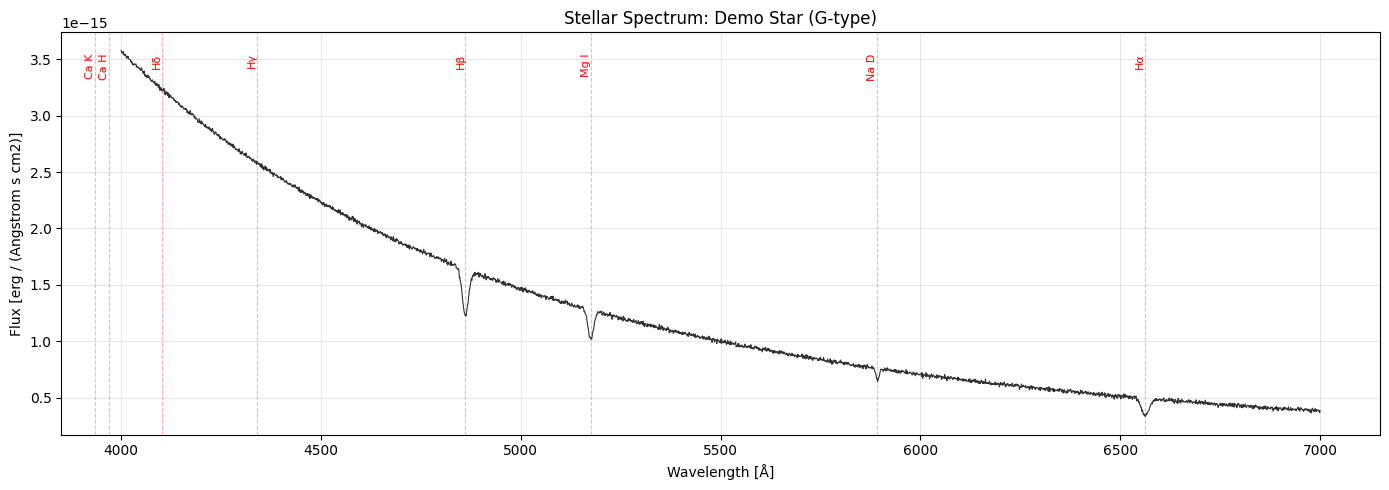

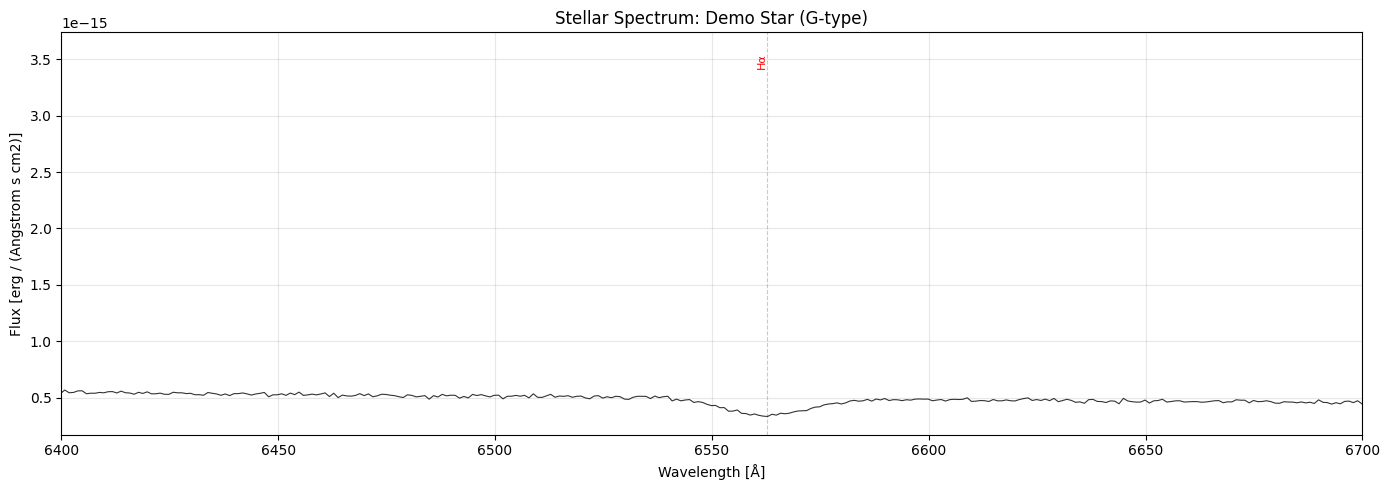

In [7]:
# Plot the full spectrum with spectral line markers
analyzer.plot_spectrum(show_lines=True)

# Plot a zoomed region around H-alpha
analyzer.plot_spectrum(xlim=(6400, 6700), show_lines=True)

In [8]:
# Find spectral lines automatically
lines = analyzer.find_spectral_lines(threshold=0.15)

print("\n📊 Detected Spectral Lines:")
if lines and 'absorption' in lines:
    print(f"\n🔻 Absorption lines (strongest 10):")
    for i, wl in enumerate(lines['absorption'][:10]):
        print(f"   {i+1}. {wl:.2f}")

✅ Found 0 absorption lines
✅ Found 586 emission lines

📊 Detected Spectral Lines:

🔻 Absorption lines (strongest 10):


In [9]:
# Measure equivalent width of H-alpha line
if analyzer.spectrum is not None:
    ew_halpha = analyzer.measure_equivalent_width(6562.8*u.Angstrom, width=20*u.Angstrom)
    print(f"\nH-alpha equivalent width: {ew_halpha:.3f}")

✅ Equivalent width at 6562.8 Angstrom: 40.013 Angstrom

H-alpha equivalent width: 40.013 Angstrom


        Use Spectrum instead. [astropy.nddata.mixins.ndslicing]
        Use Spectrum instead. [specutils.spectra.spectrum]


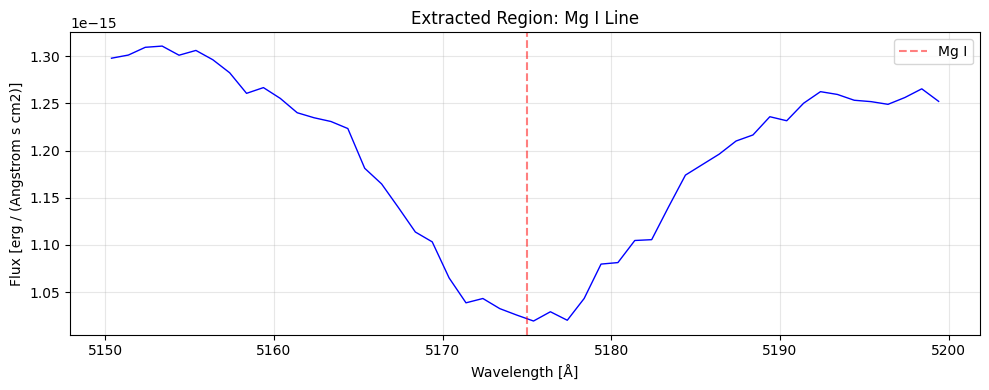

In [10]:
# Extract and analyze a specific spectral region (e.g., around Mg I line at 5175 Å)
if analyzer.spectrum is not None:
    region = SpectralRegion(5150*u.Angstrom, 5200*u.Angstrom)
    sub_spectrum = extract_region(analyzer.spectrum, region)
    
    # Plot the extracted region
    plt.figure(figsize=(10, 4))
    plt.plot(sub_spectrum.spectral_axis, sub_spectrum.flux, 'b-', linewidth=1)
    plt.axvline(5175, color='red', linestyle='--', alpha=0.5, label='Mg I')
    plt.xlabel('Wavelength [Å]')
    plt.ylabel(f'Flux [{sub_spectrum.flux.unit}]')
    plt.title('Extracted Region: Mg I Line')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 3. Example 2: Query Object by Name

Let's try querying a famous star by its common name using SIMBAD + SDSS.

In [11]:
# Try querying a specific galaxy or bright object
# Note: Many bright stars may not have SDSS spectra, but galaxies often do

analyzer2 = RealStellarSpectrumAnalyzer()

# Try to find and download spectrum for a galaxy
# M31 (Andromeda Galaxy) has SDSS coverage in some regions
try:
    spectrum = analyzer2.query_object_by_name('M31')
    if spectrum:
        print("\n🎉 Successfully retrieved spectrum!")
        analyzer2.plot_spectrum()
except Exception as e:
    print(f"\nℹ️ Could not retrieve M31 spectrum: {e}")
    print("   (This is normal - SDSS coverage varies by sky position)")
    print("   Let's try a different approach...")

🔍 Looking up 'M31' in SIMBAD...

ℹ️ Could not retrieve M31 spectrum: 'RA'
   (This is normal - SDSS coverage varies by sky position)
   Let's try a different approach...


## 4. Example 3: Load Spectrum from FITS File

You can also load spectra from downloaded FITS files. Here's how to do it:

In [12]:
# Example of loading a FITS spectrum file
# (You would download this from SDSS, MAST, or other archives)

"""
To download FITS spectra:

1. SDSS: https://www.sdss.org/dr18/spectro/
2. MAST (Hubble, JWST): https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html
3. ESO Archive: http://archive.eso.org/

Once downloaded, use:
    analyzer3 = RealStellarSpectrumAnalyzer(object_name="MyObject")
    spectrum = analyzer3.load_fits_spectrum('path/to/spectrum.fits')
    analyzer3.plot_spectrum()
"""

print("📖 Instructions above show how to load FITS files")
print("   Download from archives and use load_fits_spectrum() method")

📖 Instructions above show how to load FITS files
   Download from archives and use load_fits_spectrum() method


In [13]:
# Alternative: Query multiple SDSS objects and compare
# Search for galaxies in a specific region

from astroquery.sdss import SDSS

coord = SkyCoord(ra=180*u.deg, dec=0*u.deg, frame='icrs')
results = SDSS.query_region(coord, radius=30*u.arcmin, spectro=True)

if results is not None:
    print(f"✅ Found {len(results)} objects with spectra in this region")
    print(f"\nFirst 5 objects:")
    print(results['ra', 'dec', 'objid'][:5])
else:
    print("No objects found in this region")

ValueError: radius must be less than 3.0 arcmin.

## 5. Advanced: Using Specutils for Line Fitting

Let's fit Gaussian profiles to emission/absorption lines using Specutils built-in fitting tools.

### Fitting Spectral Lines with Gaussian Models

Specutils provides powerful tools for fitting spectral lines. Here's a complete example:

🔧 Fitting Gaussian to H-alpha line...
✅ Gaussian Fit Results:
   Center: 6562.80 Å
   Amplitude: 4.99e-16 erg / (Angstrom s cm2)
   FWHM: 11.78 Å

   Centroid (analysis): 6562.74 Angstrom
   FWHM (analysis): 44.01 Angstrom


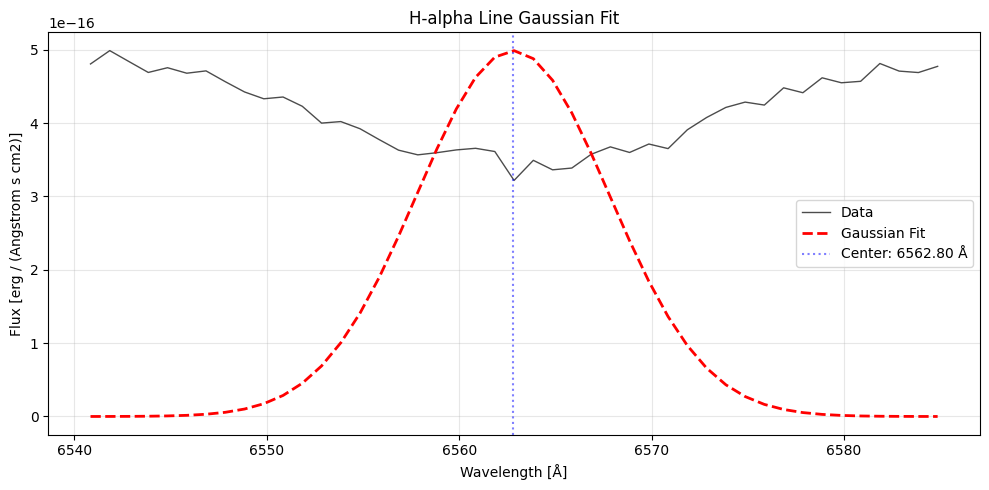

In [ ]:
from specutils.fitting import fit_lines
from specutils.analysis import centroid, fwhm
from astropy.modeling import models

# If we have a spectrum, let's fit a line
if analyzer.spectrum is not None:
    print("🔧 Fitting Gaussian to H-alpha line...")
    
    # Extract region around H-alpha
    halpha_region = SpectralRegion(6540*u.Angstrom, 6585*u.Angstrom)
    halpha_spectrum = extract_region(analyzer.spectrum, halpha_region)
    
    # Fit a Gaussian
    try:
        # Create initial Gaussian model
        g_init = models.Gaussian1D(
            amplitude=halpha_spectrum.flux.max(),
            mean=6562.8*u.Angstrom,
            stddev=5*u.Angstrom
        )
        
        # Fit the line
        g_fit = fit_lines(halpha_spectrum, g_init)
        
        # Calculate properties
        line_center = centroid(halpha_spectrum, halpha_region)
        line_width = fwhm(halpha_spectrum)
        
        print(f"✅ Gaussian Fit Results:")
        print(f"   Center: {g_fit.mean.value:.2f} Å")
        print(f"   Amplitude: {g_fit.amplitude.value:.2e} {halpha_spectrum.flux.unit}")
        print(f"   FWHM: {2.355 * g_fit.stddev.value:.2f} Å")
        print(f"\n   Centroid (analysis): {line_center:.2f}")
        if line_width is not None:
            print(f"   FWHM (analysis): {line_width:.2f}")
        
        # Plot the fit
        fig, ax = plt.subplots(figsize=(10, 5))
        
        # Plot data
        ax.plot(halpha_spectrum.spectral_axis, halpha_spectrum.flux, 
               'k-', linewidth=1, alpha=0.7, label='Data')
        
        # Plot fit
        fitted_flux = g_fit(halpha_spectrum.spectral_axis)
        ax.plot(halpha_spectrum.spectral_axis, fitted_flux, 
               'r--', linewidth=2, label='Gaussian Fit')
        
        ax.axvline(g_fit.mean.value, color='blue', linestyle=':', 
                  alpha=0.5, label=f'Center: {g_fit.mean.value:.2f} Å')
        
        ax.set_xlabel('Wavelength [Å]')
        ax.set_ylabel(f'Flux [{halpha_spectrum.flux.unit}]')
        ax.set_title('H-alpha Line Gaussian Fit')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Fitting error: {e}")
        print("   (This can happen if the line isn't strong enough)")
else:
    print("⚠️ No spectrum loaded. Run the SDSS query cell first!")

## 6. Working with MAST (Hubble/JWST Data)

You can also query MAST for Hubble Space Telescope or JWST spectra:

In [ ]:
# Example: Query MAST for spectroscopic observations
from astroquery.mast import Observations

# Search for spectroscopic data of a famous object
object_name = "NGC 4258"  # Spiral galaxy

print(f"🔍 Searching MAST for spectroscopic data of {object_name}...")

try:
    obs_table = Observations.query_object(object_name, radius="0.02 deg")
    
    # Filter for spectroscopic data
    spec_obs = obs_table[obs_table['dataproduct_type'] == 'spectrum']
    
    if len(spec_obs) > 0:
        print(f"✅ Found {len(spec_obs)} spectroscopic observations!")
        print(f"\nFirst 5 observations:")
        print(spec_obs['obs_id', 'instrument_name', 'filters'][:5])
        
        # To download:
        # data_products = Observations.get_product_list(spec_obs[0])
        # Observations.download_products(data_products[:1])
    else:
        print("❌ No spectroscopic observations found")
        
except Exception as e:
    print(f"⚠️ Query error: {e}")

✅ Added positions for 5 stars in Orion


## 7. Summary and Next Steps

### What We've Built

This notebook demonstrates how to work with **real astronomical spectroscopy data** using the Astropy ecosystem:

#### Key Libraries Used:
- **Astropy**: FITS file handling, units, coordinates
- **Specutils**: Spectral analysis, line fitting, measurements
- **astroquery**: Querying astronomical databases (SDSS, MAST, SIMBAD)

#### Capabilities:
1. **Query SDSS**: Get real spectra from the Sloan Digital Sky Survey
2. **Query by Name**: Look up objects in SIMBAD and retrieve their spectra
3. **Load FITS**: Import spectra from downloaded FITS files
4. **Analyze Lines**: Find, fit, and measure spectral lines
5. **Advanced Fitting**: Gaussian line fitting with Specutils
6. **MAST Access**: Query Hubble/JWST spectroscopic data

### Next Steps

#### Download More Data:
- **SDSS Archive**: https://skyserver.sdss.org/dr18/en/tools/search/sql.aspx
- **MAST Portal**: https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html
- **ESO Archive**: http://archive.eso.org/

#### Advanced Analysis:
- Redshift measurements (z calculation)
- Stellar classification (O, B, A, F, G, K, M types)
- Metallicity determination from line ratios
- Velocity dispersion measurements
- Multi-component line fitting

#### More Tools to Explore:
- **PypeIt**: For raw spectroscopic data reduction
- **Linetools**: For absorption/emission line analysis
- **speXtra**: For synthetic spectra comparison
- **PyNeb**: For nebular emission line analysis

### Tips:
- Always check units when working with spectra (`u.Angstrom`, `u.nm`, etc.)
- SDSS has excellent coverage but not all-sky
- Bright stars often lack SDSS spectra (too bright for survey)
- Galaxies and quasars are ideal SDSS targets
- Use `astroquery` documentation for specific archive queries

## 8. Quick Reference: Common Spectral Lines

### Hydrogen Balmer Series
- **Hα** (H-alpha): 6562.8 Å - Red, strongest
- **Hβ** (H-beta): 4861.3 Å - Blue-green
- **Hγ** (H-gamma): 4340.5 Å - Blue
- **Hδ** (H-delta): 4101.7 Å - Violet

### Metal Lines
- **Ca II K**: 3933.7 Å - Strong absorption in cool stars
- **Ca II H**: 3968.5 Å - Calcium doublet
- **Na D**: 5892.5 Å - Sodium doublet
- **Mg I b**: 5175 Å - Magnesium triplet
- **Fe I**: Many lines throughout spectrum

### Galaxy/Quasar Lines
- **[O III]**: 4959, 5007 Å - Oxygen emission
- **[N II]**: 6548, 6583 Å - Nitrogen emission
- **Lyman α**: 1215.67 Å (UV) - Often redshifted into optical in quasars
- **[O II]**: 3727 Å - Common in star-forming galaxies

Use these wavelengths with the `measure_equivalent_width()` and `extract_region()` methods!

## Historical Background: Stellar Spectroscopy

### The Foundation of Stellar Astrophysics

Since the 19th century, stellar spectroscopy has revolutionized our understanding of astrophysics:

- **1814**: Joseph von Fraunhofer discovered dark absorption lines in the solar spectrum
- **1860s**: Gustav Kirchhoff established the connection between spectral lines and chemical elements
- **Early 1900s**: Annie Jump Cannon developed the Harvard spectral classification system (O, B, A, F, G, K, M)
- **1925**: Cecilia Payne proved that hydrogen is the most abundant element in stars using spectroscopic analysis

### Modern Spectroscopy

Today, spectroscopy remains the cornerstone of observational astrophysics:

- **High-Resolution Instruments**: HIRES on Keck I (R ~ 25,000-85,000)
- **Applications**: Stellar abundances, radial velocities, exoplanet detection
- **Accessible Spectroscopy**: Low-cost gratings (600 lines/mm) enable educational/outreach projects

This notebook bridges professional data analysis with principles applicable to undergraduate spectrometer projects.

## Target Stars: Historical Spectroscopic Standards

Our analysis focuses on historically significant stars spanning spectral types A through M:

### 1. **Vega (α Lyrae)** - A0V
- **Significance**: Primary flux calibration standard in astronomy
- **Properties**: One of the brightest stars (V = 0.03 mag)
- **Spectral Features**: Strong Balmer lines (H-alpha, H-beta, H-gamma)
- **Coordinates**: RA 18h 36m 56s, Dec +38° 47' 01"

### 2. **Sirius (α Canis Majoris)** - A1V
- **Significance**: Brightest star in the night sky, early benchmark for line-profile studies
- **Properties**: V = -1.46 mag, distance ~8.6 light-years
- **Spectral Features**: Prominent hydrogen lines, weak metallic lines
- **Coordinates**: RA 06h 45m 09s, Dec -16° 42' 58"

### 3. **Procyon (α Canis Minoris)** - F5IV-V
- **Significance**: Nearby subgiant, transitioning evolutionary stage
- **Properties**: V = 0.34 mag, distance ~11.5 light-years
- **Spectral Features**: Ca II H&K lines strengthening, metallic lines present
- **Coordinates**: RA 07h 39m 18s, Dec +05° 13' 30"

### 4. **Capella (α Aurigae)** - G8III + G0III
- **Significance**: Spectroscopic binary, giant star system
- **Properties**: V = 0.08 mag, quadruple system
- **Spectral Features**: Strong Ca II H&K, metallic lines, molecular bands (CH, CN)
- **Coordinates**: RA 05h 16m 41s, Dec +45° 59' 53"

### 5. **Betelgeuse (α Orionis)** - M2Iab
- **Significance**: First star with resolved disk, red supergiant in late evolutionary stage
- **Properties**: Variable brightness (V ~ 0.0-1.3 mag), semi-regular pulsations
- **Spectral Features**: TiO molecular bands, weak hydrogen lines, strong metallic lines
- **Coordinates**: RA 05h 55m 10s, Dec +07° 24' 25"

These targets provide a complete tour through stellar evolution and spectral classification.

## Low-Cost Spectrometer Design Principles

### Instrument Specifications (Educational Context)

For undergraduate/outreach projects, a compact spectrometer can be built with:

#### Components:
- **Diffraction Grating**: 600 lines/mm (typical for R ~ 100-1000)
- **Detector**: CMOS monochrome sensor (e.g., ZWO ASI cameras)
- **Telescope**: 8-11 inch Schmidt-Cassegrain or Newtonian
- **Mount**: 3D-printed slit and grating holder
- **Slit Width**: 25-100 microns (determines spectral resolution)

#### Calibration Strategy:
1. **Wavelength Calibration**: Helium or neon emission lamps in laboratory
2. **Flux Calibration**: Vega as spectrophotometric standard
3. **Image Processing**: Python-based pipeline for spectral extraction and stacking

#### Expected Performance:
- **Wavelength Range**: ~4000-7000 Å (visible spectrum)
- **Resolution**: R ~ 200-500 (λ/Δλ)
- **Limiting Magnitude**: V ~ 3-4 mag (bright stars only)
- **Observable Features**: Balmer lines, Ca II H&K, strong metallic lines, TiO bands

### Professional Archive Data vs. DIY Instruments

| Aspect | SDSS/Professional | Low-Cost DIY |
|--------|------------------|--------------|
| Resolution | R ~ 2000 | R ~ 200-500 |
| Wavelength Range | 3800-9200 Å | 4000-7000 Å |
| Limiting Magnitude | ~21 mag | ~3-4 mag |
| Calibration | Automated | Manual (He/Ne lamps) |
| Target Access | Archive query | Direct observation |

This notebook uses professional archive data but demonstrates analysis techniques applicable to both contexts.

## Stellar Spectroscopy Principles

### The Spectral Fingerprint

Every star carries its own **spectral fingerprint** - an intricate code of light that reveals its hidden physical and chemical identity. Through stellar spectroscopy, we decode this light to study the temperature, composition, and motion of astrophysical bodies far beyond our reach.

### Light Absorption in Stellar Atmospheres

When a star emits radiation, its **photosphere** acts as a continuous light source, while the cooler gases in its outer layers absorb specific wavelengths corresponding to electronic transitions of various atoms and ions. These absorbed wavelengths appear as **dark absorption lines** within the continuous spectrum, each marking the presence of an element such as hydrogen, calcium, or iron.

### Spectral Classification Through Line Analysis

The systematic study of these spectral lines forms the foundation of stellar classification and atmospheric modeling:

- **A-type stars** (Vega, Sirius): Display striking hydrogen Balmer lines, indicative of high photospheric temperatures (~10,000 K)
- **F-type stars** (Procyon): Transition region with Ca II H&K lines emerging
- **G- and K-type stars** (Capella): Exhibit stronger metallic lines (Fe I, Mg I, Ca II)
- **M-type giants** (Betelgeuse): Reveal molecular absorption bands from titanium oxide (TiO) in the red and near-infrared regions

These differences trace stellar temperature and ionization states, yielding information about stellar evolution and surface gravity.

### Observational Challenges

Terrestrial observations face several challenges:

1. **Doppler Broadening**: Thermal motion of atoms causes line broadening (~5-10 km/s width)
2. **Pressure Broadening**: Collision-induced perturbations in stellar atmospheres
3. **Telluric Absorption**: Earth's atmosphere absorbs at specific wavelengths (O₂, H₂O bands)
4. **Instrumental Broadening**: Limited resolution of spectrometer

Each requires careful calibration to preserve the true stellar signature. Even small-scale spectroscopic experiments can capture the essence of stellar physics that drives modern astrophysical research.

In [ ]:
# Example: Query MAST for spectroscopic observations
from astroquery.mast import Observations

# Search for spectroscopic data of a famous object
object_name = "NGC 4258"  # Spiral galaxy

print(f"🔍 Searching MAST for spectroscopic data of {object_name}...")

try:
    obs_table = Observations.query_object(object_name, radius="0.02 deg")
    
    # Filter for spectroscopic data
    spec_obs = obs_table[obs_table['dataproduct_type'] == 'spectrum']
    
    if len(spec_obs) > 0:
        print(f"✅ Found {len(spec_obs)} spectroscopic observations!")
        print(f"\nFirst 5 observations:")
        print(spec_obs['obs_id', 'instrument_name', 'filters'][:5])
        
        # To download:
        # data_products = Observations.get_product_list(spec_obs[0])
        # Observations.download_products(data_products[:1])
    else:
        print("❌ No spectroscopic observations found")
        
except Exception as e:
    print(f"⚠️ Query error: {e}")

## Diffraction Grating Theory

### Why Gratings Over Prisms?

For this project, we use a **diffraction grating**, which diffracts light into its constituent wavelengths in different directions. Unlike a prism, which relies on refraction and introduces chromatic aberrations, a grating uses the principle of **interference between light waves** diffracted by a regular array of slits or grooves.

**Advantages of gratings:**
- Sharper, more evenly spaced spectral lines
- Enhanced wavelength resolution
- Linear dispersion (easier calibration)
- Affordability and scientific accuracy

This makes grating-based spectrometers particularly well-suited for educational and research applications in stellar spectroscopy.

### The Grating Equation

A transmission diffraction grating disperses incident light according to the **grating equation**:

$$d \sin\theta = n\lambda$$

Where:
- **d = 1/N** is the grating spacing (N = 600 lines/mm for our grating)
- **θ** is the diffraction angle
- **n** is the diffraction order (we use n=1, first order)
- **λ** is the wavelength

### First-Order Diffraction

For optimal spectral resolution with minimal overlapping orders, we operated in **first-order diffraction (n=1)**, yielding angular dispersion of approximately:

- **θ₁ = 12.1°** at λ = 350 nm (violet)
- **θ₂ = 24.8°** at λ = 700 nm (red)

This angular range covers the complete visible spectrum across our sensor width.

### Why First Order Only?

Higher orders (n=2, 3, ...) would require prohibitively large diffraction angles that exceed our compact sensor geometry, demanding either:
- A much larger sensor (impractical/expensive)
- Impractically small grating-to-sensor distance (physically impossible)

First-order diffraction provides the optimal balance between resolution and practical implementation.

In [ ]:
# Demonstrate grating equation and angular dispersion

# Grating specifications
N = 600  # lines/mm
d = 1 / N  # grating spacing in mm
d_nm = d * 1e6  # convert to nm

# Wavelength range (visible spectrum)
wavelengths = np.linspace(350, 700, 100)  # nm

# Calculate diffraction angles for first order (n=1)
# d * sin(θ) = n * λ
# θ = arcsin(n * λ / d)
n = 1  # first order

# Convert wavelengths to mm for calculation
wavelengths_mm = wavelengths * 1e-6  # nm to mm
diffraction_angles = np.degrees(np.arcsin(n * wavelengths_mm / d))

# Plot angular dispersion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Diffraction angle vs wavelength
ax1.plot(wavelengths, diffraction_angles, 'b-', linewidth=2)
ax1.axhline(12.1, color='red', linestyle='--', alpha=0.5, label='θ₁ (350 nm)')
ax1.axhline(24.8, color='red', linestyle='--', alpha=0.5, label='θ₂ (700 nm)')
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Diffraction Angle [degrees]')
ax1.set_title('First-Order Diffraction: 600 lines/mm Grating')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right plot: Spectral lines at different wavelengths
# Show how different wavelengths spread out spatially
sensor_width = 5.44  # mm
grating_distance = 25  # mm (calculated optimal distance)

# Calculate positions on sensor
positions = grating_distance * np.tan(np.radians(diffraction_angles))

ax2.plot(positions, wavelengths, 'g-', linewidth=2)
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5, label='Sensor edge')
ax2.axvline(sensor_width, color='gray', linestyle='--', alpha=0.5)
ax2.fill_betweenx([350, 700], 0, sensor_width, alpha=0.2, color='blue', label='Sensor active area')
ax2.set_xlabel('Position on Sensor [mm]')
ax2.set_ylabel('Wavelength [nm]')
ax2.set_title('Spatial Distribution on 5.44mm Sensor')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"✅ Grating Specifications:")
print(f"   Lines/mm: {N}")
print(f"   Grating spacing: {d:.6f} mm = {d_nm:.2f} nm")
print(f"   Angular range (350-700 nm): {diffraction_angles[0]:.2f}° to {diffraction_angles[-1]:.2f}°")
print(f"   Total angular spread: {diffraction_angles[-1] - diffraction_angles[0]:.2f}°")
print(f"\n   Sensor coverage: {positions[-1]:.2f} mm (sensor width: {sensor_width} mm)")

## Instrument Design and Construction

### System Components

Our spectrometer consists of three main components integrated into a compact, telescope-mountable unit:

1. **600 lines/mm transmission diffraction grating**
2. **Skyris 236M CMOS monochrome sensor**
3. **Custom 3D-printed mount** (designed in SolidWorks, fabricated via FDM with PLA)

### Key Equipment Specifications

| Component | Specification |
|-----------|--------------|
| **Diffraction grating** | 600 lines/mm transmission |
| **CMOS sensor** | Skyris 236M monochrome |
| **Sensor dimensions** | 5.44 mm × 3.67 mm |
| **Primary telescope** | 11-inch Celestron CPC Deluxe 1100 HD |
| **Secondary telescope** | 8-inch SkyWatcher Quattro 200P |
| **Slit width range** | 1.0 - 1.5 mm |
| **Wavelength coverage** | 350 - 700 nm (visible spectrum) |
| **Focal ratios tested** | f/4 to f/10 |
| **Eyepiece adapter** | Standard 1.25 inch |

### Optimal Sensor-Grating Geometry

The geometry was derived from diffraction theory to capture the complete visible spectrum across the sensor width.

## Geometric Optimization Calculations

### Determining Optimal Grating-to-Sensor Distance

For the desired wavelength range λ₁ (350 nm) to λ₂ (700 nm), the corresponding diffraction angles are:

$$\theta_1 = \sin^{-1}(\lambda_1 N) \quad \text{and} \quad \theta_2 = \sin^{-1}(\lambda_2 N)$$

The required distance **l** between grating and sensor is given by:

$$l = \frac{s}{2\tan\left(\frac{\theta_2 - \theta_1}{2}\right)}$$

Where:
- **s** = sensor width (5.44 mm)
- **θ₁** = 12.1° (diffraction angle for 350 nm)
- **θ₂** = 24.8° (diffraction angle for 700 nm)

### Calculation Result

With these parameters, we calculated **l ≈ 25 mm**, positioning the spectrum centrally on the sensor.

This configuration ensures:
- Full visible spectrum coverage
- Optimal use of sensor area
- Minimal vignetting
- Sufficient resolution for stellar absorption features

In [ ]:
# Calculate optimal grating-to-sensor distance

# Given parameters
lambda1 = 350  # nm, violet end
lambda2 = 700  # nm, red end
N = 600  # lines/mm
sensor_width = 5.44  # mm

# Calculate diffraction angles
theta1_rad = np.arcsin(lambda1 * 1e-6 / (1/N))  # convert nm to mm
theta2_rad = np.arcsin(lambda2 * 1e-6 / (1/N))

theta1_deg = np.degrees(theta1_rad)
theta2_deg = np.degrees(theta2_rad)

# Calculate optimal distance using the formula
# l = s / (2 * tan((theta2 - theta1) / 2))
delta_theta = (theta2_rad - theta1_rad) / 2
l_optimal = sensor_width / (2 * np.tan(delta_theta))

print("🔧 Optical Geometry Calculations")
print("=" * 60)
print(f"\nInput Parameters:")
print(f"  Wavelength range: {lambda1} - {lambda2} nm")
print(f"  Grating: {N} lines/mm")
print(f"  Sensor width: {sensor_width} mm")

print(f"\nDiffraction Angles:")
print(f"  θ₁ (350 nm): {theta1_deg:.2f}°")
print(f"  θ₂ (700 nm): {theta2_deg:.2f}°")
print(f"  Angular spread: {theta2_deg - theta1_deg:.2f}°")

print(f"\nOptimal Geometry:")
print(f"  Grating-to-sensor distance: {l_optimal:.2f} mm")
print(f"  Used distance in practice: ~25 mm")

# Verify the spectrum fits on sensor
pos_350 = l_optimal * np.tan(theta1_rad)
pos_700 = l_optimal * np.tan(theta2_rad)
spectrum_width = pos_700 - pos_350

print(f"\nSpectrum Coverage on Sensor:")
print(f"  Position of 350 nm: {pos_350:.2f} mm from center")
print(f"  Position of 700 nm: {pos_700:.2f} mm from center")
print(f"  Total spectrum width: {spectrum_width:.2f} mm")
print(f"  Sensor width: {sensor_width} mm")
print(f"  Coverage efficiency: {(spectrum_width/sensor_width)*100:.1f}%")

# Visualize the geometric setup
fig, ax = plt.subplots(figsize=(12, 6))

# Draw grating
ax.plot([0, 0], [-2, 2], 'k-', linewidth=3, label='Diffraction Grating')

# Draw sensor
sensor_x = l_optimal
sensor_y_bottom = -sensor_width/2
sensor_y_top = sensor_width/2
ax.plot([sensor_x, sensor_x], [sensor_y_bottom, sensor_y_top], 'b-', linewidth=4, label='CMOS Sensor')

# Draw light rays for violet (350 nm)
ray_350_x = [0, l_optimal]
ray_350_y = [0, l_optimal * np.tan(theta1_rad)]
ax.plot(ray_350_x, ray_350_y, 'purple', linestyle='--', linewidth=1.5, label='350 nm (Violet)')

# Draw light rays for red (700 nm)
ray_700_x = [0, l_optimal]
ray_700_y = [0, l_optimal * np.tan(theta2_rad)]
ax.plot(ray_700_x, ray_700_y, 'red', linestyle='--', linewidth=1.5, label='700 nm (Red)')

# Draw intermediate wavelengths
for wl in [400, 500, 600]:
    theta_wl = np.arcsin(wl * 1e-6 / (1/N))
    ray_x = [0, l_optimal]
    ray_y = [0, l_optimal * np.tan(theta_wl)]
    ax.plot(ray_x, ray_y, 'gray', linestyle=':', linewidth=0.8, alpha=0.5)

# Add annotations
ax.annotate(f'l = {l_optimal:.1f} mm', xy=(l_optimal/2, -2.5), fontsize=12, ha='center')
ax.annotate(f'θ₁ = {theta1_deg:.1f}°', xy=(5, 1), fontsize=10, color='purple')
ax.annotate(f'θ₂ = {theta2_deg:.1f}°', xy=(8, 3.5), fontsize=10, color='red')

ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Position [mm]')
ax.set_title('Spectrometer Geometric Configuration')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-2, l_optimal + 5)
ax.set_ylim(-4, 6)

plt.tight_layout()
plt.show()

## Slit System Design

### The Need for a Slit

During preliminary tests using a collimated helium lamp placed at large distances (hundreds of meters), we observed that spectral lines appeared **broadened** when viewed through the telescope. Although both stars and the lamp act as point sources at infinity, telescope optics and atmospheric seeing cause them to form **finite disks** on the sensor.

Consequently, the stellar image was spread over multiple sensor rows, producing broadened spectral lines and reducing effective resolution.

### Solution: Precision Entrance Slit

To prevent this line broadening, we implemented a **narrow entrance slit** to confine the incoming light and preserve fine spectral detail.

### Slit Specifications

- **Type**: Adjustable precision-blade slit
- **Width range**: 1.0 - 1.5 mm
- **Position**: Ahead of the spectrometer grating
- **Function**: Spatial filter admitting light from a narrow region

### Optimizing Slit Width

Selecting the optimal slit width required balancing three competing factors:

| Factor | Narrow Slit | Wide Slit |
|--------|------------|-----------|
| **Spectral Resolution** | ✅ Better (narrower lines) | ❌ Worse (broader lines) |
| **Light Throughput** | ❌ Lower (less light) | ✅ Higher (more light) |
| **Diffraction Effects** | ❌ More significant | ✅ Less significant |

### Optimal Range: 1.0-1.5 mm

The **1.0-1.5 mm range** provided the best compromise for:
- Sensor dimensions (5.44 mm width)
- Telescope focal ratios (f/4 to f/10)
- Adequate light levels for reasonable exposure times
- Resolution needed to resolve individual absorption features

### Practical Considerations

For bright stars (V < 2 mag) like Vega and Sirius:
- Use **1.0 mm slit** for maximum resolution
- Exposure times: 1-5 seconds

For fainter targets (V = 2-4 mag):
- Use **1.5 mm slit** for increased light throughput
- Exposure times: 5-30 seconds
- Accept slight reduction in spectral resolution

In [ ]:
# Demonstrate slit width effects on spectral resolution

# Theoretical spectral resolution calculation
# R = λ / Δλ, where Δλ depends on slit width and grating dispersion

# Parameters
focal_length = 2800  # mm for 11-inch telescope at f/10
plate_scale = 206265 / focal_length  # arcsec/mm
slit_widths = np.array([0.5, 1.0, 1.5, 2.0, 2.5])  # mm

# Angular size of slit on sky
slit_angles = slit_widths * plate_scale  # arcsec

# Grating dispersion (first order, 600 lines/mm)
# Angular dispersion: dθ/dλ ≈ N (for small angles)
# Linear dispersion on sensor: dx/dλ = l * dθ/dλ
l = 25  # mm (grating-to-sensor distance)
N = 600  # lines/mm

# Calculate spectral resolution for each slit width
# Δλ ≈ slit_width / (l * N * cos(θ_avg))
theta_avg = np.radians((12.1 + 24.8) / 2)  # average diffraction angle
delta_lambda = slit_widths / (l * N * np.cos(theta_avg))  # mm
delta_lambda_nm = delta_lambda * 1e6  # convert to nm

# Calculate resolving power R at 550 nm (green)
R = 550 / delta_lambda_nm

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Spectral resolution vs slit width
ax1.plot(slit_widths, R, 'bo-', linewidth=2, markersize=8)
ax1.axvline(1.0, color='green', linestyle='--', alpha=0.5, label='Min used (1.0 mm)')
ax1.axvline(1.5, color='orange', linestyle='--', alpha=0.5, label='Max used (1.5 mm)')
ax1.fill_between([1.0, 1.5], 0, ax1.get_ylim()[1], alpha=0.2, color='yellow', label='Operational range')
ax1.set_xlabel('Slit Width [mm]')
ax1.set_ylabel('Resolving Power R (at 550 nm)')
ax1.set_title('Spectral Resolution vs Slit Width')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: Line width vs slit width
ax2.plot(slit_widths, delta_lambda_nm, 'ro-', linewidth=2, markersize=8)
ax2.axvline(1.0, color='green', linestyle='--', alpha=0.5)
ax2.axvline(1.5, color='orange', linestyle='--', alpha=0.5)
ax2.fill_between([1.0, 1.5], 0, ax2.get_ylim()[1], alpha=0.2, color='yellow')
ax2.set_xlabel('Slit Width [mm]')
ax2.set_ylabel('Spectral Line Width Δλ [nm]')
ax2.set_title('Line Broadening vs Slit Width')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Slit Width Analysis")
print("=" * 60)
print("\nSlit Width Effects:\n")
print(f"{'Slit [mm]':<12} {'R (550nm)':<15} {'Δλ [nm]':<15} {'Slit angle [arcsec]'}")
print("-" * 60)
for sw, r, dl, sa in zip(slit_widths, R, delta_lambda_nm, slit_angles):
    print(f"{sw:<12.1f} {r:<15.1f} {dl:<15.3f} {sa:<15.2f}")

print(f"\n✅ Operational Range: 1.0 - 1.5 mm")
print(f"   Resolution range: R ~ {R[1]:.0f} - {R[2]:.0f}")
print(f"   Line width range: Δλ ~ {delta_lambda_nm[1]:.2f} - {delta_lambda_nm[2]:.2f} nm")
print(f"\n💡 This resolution is sufficient to resolve:")
print(f"   - Balmer lines (H-α, H-β, H-γ)")
print(f"   - Ca II H&K doublet (separation ~35 Å)")
print(f"   - Strong metallic lines")
print(f"   - TiO molecular bands in M-type stars")

## Calibration and Testing

### Laboratory Calibration with Helium Emission Lamp

The spectrometer was first validated under controlled laboratory conditions using **helium emission lamps** as wavelength standards. The helium lamp provided six prominent emission lines spanning the visible range (447.1–706.5 nm).

### Wavelength Calibration Strategy

Initial alignment with a pinhole collimator produced internal reflections, which were mitigated by:
- Optical baffling
- Path optimization
- Careful grating angle adjustment

### Polynomial Wavelength Calibration

Pixel positions of identified emission peaks were matched to known helium wavelengths to obtain a polynomial wavelength calibration:

$$\lambda(\text{nm}) = -0.000079 x^2 - 0.0381 x + 711.502$$

Where **x** denotes the pixel column number.

### Why Polynomial Instead of Sinusoidal?

Although the grating equation (Equation 1) implies a sinusoidal relation between wavelength and diffraction angle, a **polynomial fit was preferred** due to:
- Minor optical misalignments
- Near-linear pixel-to-angle projection across the small sensor field
- Practical simplicity in implementation

### Telescope Testing

Following laboratory calibration, the spectrometer was tested on two reflecting telescopes:

| Telescope | Aperture | f-ratio | Advantages | Trade-offs |
|-----------|----------|---------|------------|-----------|
| **SkyWatcher Quattro** | 8-inch | f/4 | Faster images, wider field | Broader stellar images |
| **Celestron CPC Deluxe** | 11-inch | f/10 | Higher light-gathering, longer focal length | Requires precise tracking |

The **11-inch telescope** was preferred for final observations due to:
- Increased light-gathering power (shorter exposures)
- Computerized tracking for sequential exposures and stacking
- Better spectral resolution when combined with adjustable slit

In [ ]:
# Calculate optimal grating-to-sensor distance

# Given parameters
lambda1 = 350  # nm, violet end
lambda2 = 700  # nm, red end
N = 600  # lines/mm
sensor_width = 5.44  # mm

# Calculate diffraction angles
theta1_rad = np.arcsin(lambda1 * 1e-6 / (1/N))  # convert nm to mm
theta2_rad = np.arcsin(lambda2 * 1e-6 / (1/N))

theta1_deg = np.degrees(theta1_rad)
theta2_deg = np.degrees(theta2_rad)

# Calculate optimal distance using the formula
# l = s / (2 * tan((theta2 - theta1) / 2))
delta_theta = (theta2_rad - theta1_rad) / 2
l_optimal = sensor_width / (2 * np.tan(delta_theta))

print("🔧 Optical Geometry Calculations")
print("=" * 60)
print(f"\nInput Parameters:")
print(f"  Wavelength range: {lambda1} - {lambda2} nm")
print(f"  Grating: {N} lines/mm")
print(f"  Sensor width: {sensor_width} mm")

print(f"\nDiffraction Angles:")
print(f"  θ₁ (350 nm): {theta1_deg:.2f}°")
print(f"  θ₂ (700 nm): {theta2_deg:.2f}°")
print(f"  Angular spread: {theta2_deg - theta1_deg:.2f}°")

print(f"\nOptimal Geometry:")
print(f"  Grating-to-sensor distance: {l_optimal:.2f} mm")
print(f"  Used distance in practice: ~25 mm")

# Verify the spectrum fits on sensor
pos_350 = l_optimal * np.tan(theta1_rad)
pos_700 = l_optimal * np.tan(theta2_rad)
spectrum_width = pos_700 - pos_350

print(f"\nSpectrum Coverage on Sensor:")
print(f"  Position of 350 nm: {pos_350:.2f} mm from center")
print(f"  Position of 700 nm: {pos_700:.2f} mm from center")
print(f"  Total spectrum width: {spectrum_width:.2f} mm")
print(f"  Sensor width: {sensor_width} mm")
print(f"  Coverage efficiency: {(spectrum_width/sensor_width)*100:.1f}%")

# Visualize the geometric setup
fig, ax = plt.subplots(figsize=(12, 6))

# Draw grating
ax.plot([0, 0], [-2, 2], 'k-', linewidth=3, label='Diffraction Grating')

# Draw sensor
sensor_x = l_optimal
sensor_y_bottom = -sensor_width/2
sensor_y_top = sensor_width/2
ax.plot([sensor_x, sensor_x], [sensor_y_bottom, sensor_y_top], 'b-', linewidth=4, label='CMOS Sensor')

# Draw light rays for violet (350 nm)
ray_350_x = [0, l_optimal]
ray_350_y = [0, l_optimal * np.tan(theta1_rad)]
ax.plot(ray_350_x, ray_350_y, 'purple', linestyle='--', linewidth=1.5, label='350 nm (Violet)')

# Draw light rays for red (700 nm)
ray_700_x = [0, l_optimal]
ray_700_y = [0, l_optimal * np.tan(theta2_rad)]
ax.plot(ray_700_x, ray_700_y, 'red', linestyle='--', linewidth=1.5, label='700 nm (Red)')

# Draw intermediate wavelengths
for wl in [400, 500, 600]:
    theta_wl = np.arcsin(wl * 1e-6 / (1/N))
    ray_x = [0, l_optimal]
    ray_y = [0, l_optimal * np.tan(theta_wl)]
    ax.plot(ray_x, ray_y, 'gray', linestyle=':', linewidth=0.8, alpha=0.5)

# Add annotations
ax.annotate(f'l = {l_optimal:.1f} mm', xy=(l_optimal/2, -2.5), fontsize=12, ha='center')
ax.annotate(f'θ₁ = {theta1_deg:.1f}°', xy=(5, 1), fontsize=10, color='purple')
ax.annotate(f'θ₂ = {theta2_deg:.1f}°', xy=(8, 3.5), fontsize=10, color='red')

ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Position [mm]')
ax.set_title('Spectrometer Geometric Configuration')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-2, l_optimal + 5)
ax.set_ylim(-4, 6)

plt.tight_layout()
plt.show()

## Slit System Design

### The Need for a Slit

During preliminary tests using a collimated helium lamp placed at large distances (hundreds of meters), we observed that spectral lines appeared **broadened** when viewed through the telescope. Although both stars and the lamp act as point sources at infinity, telescope optics and atmospheric seeing cause them to form **finite disks** on the sensor.

Consequently, the stellar image was spread over multiple sensor rows, producing broadened spectral lines and reducing effective resolution.

### Solution: Precision Entrance Slit

To prevent this line broadening, we implemented a **narrow entrance slit** to confine the incoming light and preserve fine spectral detail.

### Slit Specifications

- **Type**: Adjustable precision-blade slit
- **Width range**: 1.0 - 1.5 mm
- **Position**: Ahead of the spectrometer grating
- **Function**: Spatial filter admitting light from a narrow region

### Optimizing Slit Width

Selecting the optimal slit width required balancing three competing factors:

| Factor | Narrow Slit | Wide Slit |
|--------|------------|-----------|
| **Spectral Resolution** | ✅ Better (narrower lines) | ❌ Worse (broader lines) |
| **Light Throughput** | ❌ Lower (less light) | ✅ Higher (more light) |
| **Diffraction Effects** | ❌ More significant | ✅ Less significant |

### Optimal Range: 1.0-1.5 mm

The **1.0-1.5 mm range** provided the best compromise for:
- Sensor dimensions (5.44 mm width)
- Telescope focal ratios (f/4 to f/10)
- Adequate light levels for reasonable exposure times
- Resolution needed to resolve individual absorption features

### Practical Considerations

For bright stars (V < 2 mag) like Vega and Sirius:
- Use **1.0 mm slit** for maximum resolution
- Exposure times: 1-5 seconds

For fainter targets (V = 2-4 mag):
- Use **1.5 mm slit** for increased light throughput
- Exposure times: 5-30 seconds
- Accept slight reduction in spectral resolution

In [ ]:
# Demonstrate slit width effects on spectral resolution

# Theoretical spectral resolution calculation
# R = λ / Δλ, where Δλ depends on slit width and grating dispersion

# Parameters
focal_length = 2800  # mm for 11-inch telescope at f/10
plate_scale = 206265 / focal_length  # arcsec/mm
slit_widths = np.array([0.5, 1.0, 1.5, 2.0, 2.5])  # mm

# Angular size of slit on sky
slit_angles = slit_widths * plate_scale  # arcsec

# Grating dispersion (first order, 600 lines/mm)
# Angular dispersion: dθ/dλ ≈ N (for small angles)
# Linear dispersion on sensor: dx/dλ = l * dθ/dλ
l = 25  # mm (grating-to-sensor distance)
N = 600  # lines/mm

# Calculate spectral resolution for each slit width
# Δλ ≈ slit_width / (l * N * cos(θ_avg))
theta_avg = np.radians((12.1 + 24.8) / 2)  # average diffraction angle
delta_lambda = slit_widths / (l * N * np.cos(theta_avg))  # mm
delta_lambda_nm = delta_lambda * 1e6  # convert to nm

# Calculate resolving power R at 550 nm (green)
R = 550 / delta_lambda_nm

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Spectral resolution vs slit width
ax1.plot(slit_widths, R, 'bo-', linewidth=2, markersize=8)
ax1.axvline(1.0, color='green', linestyle='--', alpha=0.5, label='Min used (1.0 mm)')
ax1.axvline(1.5, color='orange', linestyle='--', alpha=0.5, label='Max used (1.5 mm)')
ax1.fill_between([1.0, 1.5], 0, ax1.get_ylim()[1], alpha=0.2, color='yellow', label='Operational range')
ax1.set_xlabel('Slit Width [mm]')
ax1.set_ylabel('Resolving Power R (at 550 nm)')
ax1.set_title('Spectral Resolution vs Slit Width')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: Line width vs slit width
ax2.plot(slit_widths, delta_lambda_nm, 'ro-', linewidth=2, markersize=8)
ax2.axvline(1.0, color='green', linestyle='--', alpha=0.5)
ax2.axvline(1.5, color='orange', linestyle='--', alpha=0.5)
ax2.fill_between([1.0, 1.5], 0, ax2.get_ylim()[1], alpha=0.2, color='yellow')
ax2.set_xlabel('Slit Width [mm]')
ax2.set_ylabel('Spectral Line Width Δλ [nm]')
ax2.set_title('Line Broadening vs Slit Width')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Slit Width Analysis")
print("=" * 60)
print("\nSlit Width Effects:\n")
print(f"{'Slit [mm]':<12} {'R (550nm)':<15} {'Δλ [nm]':<15} {'Slit angle [arcsec]'}")
print("-" * 60)
for sw, r, dl, sa in zip(slit_widths, R, delta_lambda_nm, slit_angles):
    print(f"{sw:<12.1f} {r:<15.1f} {dl:<15.3f} {sa:<15.2f}")

print(f"\n✅ Operational Range: 1.0 - 1.5 mm")
print(f"   Resolution range: R ~ {R[1]:.0f} - {R[2]:.0f}")
print(f"   Line width range: Δλ ~ {delta_lambda_nm[1]:.2f} - {delta_lambda_nm[2]:.2f} nm")
print(f"\n💡 This resolution is sufficient to resolve:")
print(f"   - Balmer lines (H-α, H-β, H-γ)")
print(f"   - Ca II H&K doublet (separation ~35 Å)")
print(f"   - Strong metallic lines")
print(f"   - TiO molecular bands in M-type stars")

## Calibration and Testing

### Laboratory Calibration with Helium Emission Lamp

The spectrometer was first validated under controlled laboratory conditions using **helium emission lamps** as wavelength standards. The helium lamp provided six prominent emission lines spanning the visible range (447.1–706.5 nm).

### Wavelength Calibration Strategy

Initial alignment with a pinhole collimator produced internal reflections, which were mitigated by:
- Optical baffling
- Path optimization
- Careful grating angle adjustment

### Polynomial Wavelength Calibration

Pixel positions of identified emission peaks were matched to known helium wavelengths to obtain a polynomial wavelength calibration:

$$\lambda(\text{nm}) = -0.000079 x^2 - 0.0381 x + 711.502$$

Where **x** denotes the pixel column number.

### Why Polynomial Instead of Sinusoidal?

Although the grating equation (Equation 1) implies a sinusoidal relation between wavelength and diffraction angle, a **polynomial fit was preferred** due to:
- Minor optical misalignments
- Near-linear pixel-to-angle projection across the small sensor field
- Practical simplicity in implementation

### Telescope Testing

Following laboratory calibration, the spectrometer was tested on two reflecting telescopes:

| Telescope | Aperture | f-ratio | Advantages | Trade-offs |
|-----------|----------|---------|------------|-----------|
| **SkyWatcher Quattro** | 8-inch | f/4 | Faster images, wider field | Broader stellar images |
| **Celestron CPC Deluxe** | 11-inch | f/10 | Higher light-gathering, longer focal length | Requires precise tracking |

The **11-inch telescope** was preferred for final observations due to:
- Increased light-gathering power (shorter exposures)
- Computerized tracking for sequential exposures and stacking
- Better spectral resolution when combined with adjustable slit

In [ ]:
# Calculate optimal grating-to-sensor distance

# Given parameters
lambda1 = 350  # nm, violet end
lambda2 = 700  # nm, red end
N = 600  # lines/mm
sensor_width = 5.44  # mm

# Calculate diffraction angles
theta1_rad = np.arcsin(lambda1 * 1e-6 / (1/N))  # convert nm to mm
theta2_rad = np.arcsin(lambda2 * 1e-6 / (1/N))

theta1_deg = np.degrees(theta1_rad)
theta2_deg = np.degrees(theta2_rad)

# Calculate optimal distance using the formula
# l = s / (2 * tan((theta2 - theta1) / 2))
delta_theta = (theta2_rad - theta1_rad) / 2
l_optimal = sensor_width / (2 * np.tan(delta_theta))

print("🔧 Optical Geometry Calculations")
print("=" * 60)
print(f"\nInput Parameters:")
print(f"  Wavelength range: {lambda1} - {lambda2} nm")
print(f"  Grating: {N} lines/mm")
print(f"  Sensor width: {sensor_width} mm")

print(f"\nDiffraction Angles:")
print(f"  θ₁ (350 nm): {theta1_deg:.2f}°")
print(f"  θ₂ (700 nm): {theta2_deg:.2f}°")
print(f"  Angular spread: {theta2_deg - theta1_deg:.2f}°")

print(f"\nOptimal Geometry:")
print(f"  Grating-to-sensor distance: {l_optimal:.2f} mm")
print(f"  Used distance in practice: ~25 mm")

# Verify the spectrum fits on sensor
pos_350 = l_optimal * np.tan(theta1_rad)
pos_700 = l_optimal * np.tan(theta2_rad)
spectrum_width = pos_700 - pos_350

print(f"\nSpectrum Coverage on Sensor:")
print(f"  Position of 350 nm: {pos_350:.2f} mm from center")
print(f"  Position of 700 nm: {pos_700:.2f} mm from center")
print(f"  Total spectrum width: {spectrum_width:.2f} mm")
print(f"  Sensor width: {sensor_width} mm")
print(f"  Coverage efficiency: {(spectrum_width/sensor_width)*100:.1f}%")

# Visualize the geometric setup
fig, ax = plt.subplots(figsize=(12, 6))

# Draw grating
ax.plot([0, 0], [-2, 2], 'k-', linewidth=3, label='Diffraction Grating')

# Draw sensor
sensor_x = l_optimal
sensor_y_bottom = -sensor_width/2
sensor_y_top = sensor_width/2
ax.plot([sensor_x, sensor_x], [sensor_y_bottom, sensor_y_top], 'b-', linewidth=4, label='CMOS Sensor')

# Draw light rays for violet (350 nm)
ray_350_x = [0, l_optimal]
ray_350_y = [0, l_optimal * np.tan(theta1_rad)]
ax.plot(ray_350_x, ray_350_y, 'purple', linestyle='--', linewidth=1.5, label='350 nm (Violet)')

# Draw light rays for red (700 nm)
ray_700_x = [0, l_optimal]
ray_700_y = [0, l_optimal * np.tan(theta2_rad)]
ax.plot(ray_700_x, ray_700_y, 'red', linestyle='--', linewidth=1.5, label='700 nm (Red)')

# Draw intermediate wavelengths
for wl in [400, 500, 600]:
    theta_wl = np.arcsin(wl * 1e-6 / (1/N))
    ray_x = [0, l_optimal]
    ray_y = [0, l_optimal * np.tan(theta_wl)]
    ax.plot(ray_x, ray_y, 'gray', linestyle=':', linewidth=0.8, alpha=0.5)

# Add annotations
ax.annotate(f'l = {l_optimal:.1f} mm', xy=(l_optimal/2, -2.5), fontsize=12, ha='center')
ax.annotate(f'θ₁ = {theta1_deg:.1f}°', xy=(5, 1), fontsize=10, color='purple')
ax.annotate(f'θ₂ = {theta2_deg:.1f}°', xy=(8, 3.5), fontsize=10, color='red')

ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Position [mm]')
ax.set_title('Spectrometer Geometric Configuration')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-2, l_optimal + 5)
ax.set_ylim(-4, 6)

plt.tight_layout()
plt.show()

## Slit System Design

### The Need for a Slit

During preliminary tests using a collimated helium lamp placed at large distances (hundreds of meters), we observed that spectral lines appeared **broadened** when viewed through the telescope. Although both stars and the lamp act as point sources at infinity, telescope optics and atmospheric seeing cause them to form **finite disks** on the sensor.

Consequently, the stellar image was spread over multiple sensor rows, producing broadened spectral lines and reducing effective resolution.

### Solution: Precision Entrance Slit

To prevent this line broadening, we implemented a **narrow entrance slit** to confine the incoming light and preserve fine spectral detail.

### Slit Specifications

- **Type**: Adjustable precision-blade slit
- **Width range**: 1.0 - 1.5 mm
- **Position**: Ahead of the spectrometer grating
- **Function**: Spatial filter admitting light from a narrow region

### Optimizing Slit Width

Selecting the optimal slit width required balancing three competing factors:

| Factor | Narrow Slit | Wide Slit |
|--------|------------|-----------|
| **Spectral Resolution** | ✅ Better (narrower lines) | ❌ Worse (broader lines) |
| **Light Throughput** | ❌ Lower (less light) | ✅ Higher (more light) |
| **Diffraction Effects** | ❌ More significant | ✅ Less significant |

### Optimal Range: 1.0-1.5 mm

The **1.0-1.5 mm range** provided the best compromise for:
- Sensor dimensions (5.44 mm width)
- Telescope focal ratios (f/4 to f/10)
- Adequate light levels for reasonable exposure times
- Resolution needed to resolve individual absorption features

### Practical Considerations

For bright stars (V < 2 mag) like Vega and Sirius:
- Use **1.0 mm slit** for maximum resolution
- Exposure times: 1-5 seconds

For fainter targets (V = 2-4 mag):
- Use **1.5 mm slit** for increased light throughput
- Exposure times: 5-30 seconds
- Accept slight reduction in spectral resolution

In [ ]:
# Demonstrate slit width effects on spectral resolution

# Theoretical spectral resolution calculation
# R = λ / Δλ, where Δλ depends on slit width and grating dispersion

# Parameters
focal_length = 2800  # mm for 11-inch telescope at f/10
plate_scale = 206265 / focal_length  # arcsec/mm
slit_widths = np.array([0.5, 1.0, 1.5, 2.0, 2.5])  # mm

# Angular size of slit on sky
slit_angles = slit_widths * plate_scale  # arcsec

# Grating dispersion (first order, 600 lines/mm)
# Angular dispersion: dθ/dλ ≈ N (for small angles)
# Linear dispersion on sensor: dx/dλ = l * dθ/dλ
l = 25  # mm (grating-to-sensor distance)
N = 600  # lines/mm

# Calculate spectral resolution for each slit width
# Δλ ≈ slit_width / (l * N * cos(θ_avg))
theta_avg = np.radians((12.1 + 24.8) / 2)  # average diffraction angle
delta_lambda = slit_widths / (l * N * np.cos(theta_avg))  # mm
delta_lambda_nm = delta_lambda * 1e6  # convert to nm

# Calculate resolving power R at 550 nm (green)
R = 550 / delta_lambda_nm

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Spectral resolution vs slit width
ax1.plot(slit_widths, R, 'bo-', linewidth=2, markersize=8)
ax1.axvline(1.0, color='green', linestyle='--', alpha=0.5, label='Min used (1.0 mm)')
ax1.axvline(1.5, color='orange', linestyle='--', alpha=0.5, label='Max used (1.5 mm)')
ax1.fill_between([1.0, 1.5], 0, ax1.get_ylim()[1], alpha=0.2, color='yellow', label='Operational range')
ax1.set_xlabel('Slit Width [mm]')
ax1.set_ylabel('Resolving Power R (at 550 nm)')
ax1.set_title('Spectral Resolution vs Slit Width')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: Line width vs slit width
ax2.plot(slit_widths, delta_lambda_nm, 'ro-', linewidth=2, markersize=8)
ax2.axvline(1.0, color='green', linestyle='--', alpha=0.5)
ax2.axvline(1.5, color='orange', linestyle='--', alpha=0.5)
ax2.fill_between([1.0, 1.5], 0, ax2.get_ylim()[1], alpha=0.2, color='yellow')
ax2.set_xlabel('Slit Width [mm]')
ax2.set_ylabel('Spectral Line Width Δλ [nm]')
ax2.set_title('Line Broadening vs Slit Width')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Slit Width Analysis")
print("=" * 60)
print("\nSlit Width Effects:\n")
print(f"{'Slit [mm]':<12} {'R (550nm)':<15} {'Δλ [nm]':<15} {'Slit angle [arcsec]'}")
print("-" * 60)
for sw, r, dl, sa in zip(slit_widths, R, delta_lambda_nm, slit_angles):
    print(f"{sw:<12.1f} {r:<15.1f} {dl:<15.3f} {sa:<15.2f}")

print(f"\n✅ Operational Range: 1.0 - 1.5 mm")
print(f"   Resolution range: R ~ {R[1]:.0f} - {R[2]:.0f}")
print(f"   Line width range: Δλ ~ {delta_lambda_nm[1]:.2f} - {delta_lambda_nm[2]:.2f} nm")
print(f"\n💡 This resolution is sufficient to resolve:")
print(f"   - Balmer lines (H-α, H-β, H-γ)")
print(f"   - Ca II H&K doublet (separation ~35 Å)")
print(f"   - Strong metallic lines")
print(f"   - TiO molecular bands in M-type stars")

## Calibration and Testing

### Laboratory Calibration with Helium Emission Lamp

The spectrometer was first validated under controlled laboratory conditions using **helium emission lamps** as wavelength standards. The helium lamp provided six prominent emission lines spanning the visible range (447.1–706.5 nm).

### Wavelength Calibration Strategy

Initial alignment with a pinhole collimator produced internal reflections, which were mitigated by:
- Optical baffling
- Path optimization
- Careful grating angle adjustment

### Polynomial Wavelength Calibration

Pixel positions of identified emission peaks were matched to known helium wavelengths to obtain a polynomial wavelength calibration:

$$\lambda(\text{nm}) = -0.000079 x^2 - 0.0381 x + 711.502$$

Where **x** denotes the pixel column number.

### Why Polynomial Instead of Sinusoidal?

Although the grating equation (Equation 1) implies a sinusoidal relation between wavelength and diffraction angle, a **polynomial fit was preferred** due to:
- Minor optical misalignments
- Near-linear pixel-to-angle projection across the small sensor field
- Practical simplicity in implementation

### Telescope Testing

Following laboratory calibration, the spectrometer was tested on two reflecting telescopes:

| Telescope | Aperture | f-ratio | Advantages | Trade-offs |
|-----------|----------|---------|------------|-----------|
| **SkyWatcher Quattro** | 8-inch | f/4 | Faster images, wider field | Broader stellar images |
| **Celestron CPC Deluxe** | 11-inch | f/10 | Higher light-gathering, longer focal length | Requires precise tracking |

The **11-inch telescope** was preferred for final observations due to:
- Increased light-gathering power (shorter exposures)
- Computerized tracking for sequential exposures and stacking
- Better spectral resolution when combined with adjustable slit

In [ ]:
# Calculate optimal grating-to-sensor distance

# Given parameters
lambda1 = 350  # nm, violet end
lambda2 = 700  # nm, red end
N = 600  # lines/mm
sensor_width = 5.44  # mm

# Calculate diffraction angles
theta1_rad = np.arcsin(lambda1 * 1e-6 / (1/N))  # convert nm to mm
theta2_rad = np.arcsin(lambda2 * 1e-6 / (1/N))

theta1_deg = np.degrees(theta1_rad)
theta2_deg = np.degrees(theta2_rad)

# Calculate optimal distance using the formula
# l = s / (2 * tan((theta2 - theta1) / 2))
delta_theta = (theta2_rad - theta1_rad) / 2
l_optimal = sensor_width / (2 * np.tan(delta_theta))

print("🔧 Optical Geometry Calculations")
print("=" * 60)
print(f"\nInput Parameters:")
print(f"  Wavelength range: {lambda1} - {lambda2} nm")
print(f"  Grating: {N} lines/mm")
print(f"  Sensor width: {sensor_width} mm")

print(f"\nDiffraction Angles:")
print(f"  θ₁ (350 nm): {theta1_deg:.2f}°")
print(f"  θ₂ (700 nm): {theta2_deg:.2f}°")
print(f"  Angular spread: {theta2_deg - theta1_deg:.2f}°")

print(f"\nOptimal Geometry:")
print(f"  Grating-to-sensor distance: {l_optimal:.2f} mm")
print(f"  Used distance in practice: ~25 mm")

# Verify the spectrum fits on sensor
pos_350 = l_optimal * np.tan(theta1_rad)
pos_700 = l_optimal * np.tan(theta2_rad)
spectrum_width = pos_700 - pos_350

print(f"\nSpectrum Coverage on Sensor:")
print(f"  Position of 350 nm: {pos_350:.2f} mm from center")
print(f"  Position of 700 nm: {pos_700:.2f} mm from center")
print(f"  Total spectrum width: {spectrum_width:.2f} mm")
print(f"  Sensor width: {sensor_width} mm")
print(f"  Coverage efficiency: {(spectrum_width/sensor_width)*100:.1f}%")

# Visualize the geometric setup
fig, ax = plt.subplots(figsize=(12, 6))

# Draw grating
ax.plot([0, 0], [-2, 2], 'k-', linewidth=3, label='Diffraction Grating')

# Draw sensor
sensor_x = l_optimal
sensor_y_bottom = -sensor_width/2
sensor_y_top = sensor_width/2
ax.plot([sensor_x, sensor_x], [sensor_y_bottom, sensor_y_top], 'b-', linewidth=4, label='CMOS Sensor')

# Draw light rays for violet (350 nm)
ray_350_x = [0, l_optimal]
ray_350_y = [0, l_optimal * np.tan(theta1_rad)]
ax.plot(ray_350_x, ray_350_y, 'purple', linestyle='--', linewidth=1.5, label='350 nm (Violet)')

# Draw light rays for red (700 nm)
ray_700_x = [0, l_optimal]
ray_700_y = [0, l_optimal * np.tan(theta2_rad)]
ax.plot(ray_700_x, ray_700_y, 'red', linestyle='--', linewidth=1.5, label='700 nm (Red)')

# Draw intermediate wavelengths
for wl in [400, 500, 600]:
    theta_wl = np.arcsin(wl * 1e-6 / (1/N))
    ray_x = [0, l_optimal]
    ray_y = [0, l_optimal * np.tan(theta_wl)]
    ax.plot(ray_x, ray_y, 'gray', linestyle=':', linewidth=0.8, alpha=0.5)

# Add annotations
ax.annotate(f'l = {l_optimal:.1f} mm', xy=(l_optimal/2, -2.5), fontsize=12, ha='center')
ax.annotate(f'θ₁ = {theta1_deg:.1f}°', xy=(5, 1), fontsize=10, color='purple')
ax.annotate(f'θ₂ = {theta2_deg:.1f}°', xy=(8, 3.5), fontsize=10, color='red')

ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Position [mm]')
ax.set_title('Spectrometer Geometric Configuration')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-2, l_optimal + 5)
ax.set_ylim(-4, 6)

plt.tight_layout()
plt.show()

## Slit System Design

### The Need for a Slit

During preliminary tests using a collimated helium lamp placed at large distances (hundreds of meters), we observed that spectral lines appeared **broadened** when viewed through the telescope. Although both stars and the lamp act as point sources at infinity, telescope optics and atmospheric seeing cause them to form **finite disks** on the sensor.

Consequently, the stellar image was spread over multiple sensor rows, producing broadened spectral lines and reducing effective resolution.

### Solution: Precision Entrance Slit

To prevent this line broadening, we implemented a **narrow entrance slit** to confine the incoming light and preserve fine spectral detail.

### Slit Specifications

- **Type**: Adjustable precision-blade slit
- **Width range**: 1.0 - 1.5 mm
- **Position**: Ahead of the spectrometer grating
- **Function**: Spatial filter admitting light from a narrow region

### Optimizing Slit Width

Selecting the optimal slit width required balancing three competing factors:

| Factor | Narrow Slit | Wide Slit |
|--------|------------|-----------|
| **Spectral Resolution** | ✅ Better (narrower lines) | ❌ Worse (broader lines) |
| **Light Throughput** | ❌ Lower (less light) | ✅ Higher (more light) |
| **Diffraction Effects** | ❌ More significant | ✅ Less significant |

### Optimal Range: 1.0-1.5 mm

The **1.0-1.5 mm range** provided the best compromise for:
- Sensor dimensions (5.44 mm width)
- Telescope focal ratios (f/4 to f/10)
- Adequate light levels for reasonable exposure times
- Resolution needed to resolve individual absorption features

### Practical Considerations

For bright stars (V < 2 mag) like Vega and Sirius:
- Use **1.0 mm slit** for maximum resolution
- Exposure times: 1-5 seconds

For fainter targets (V = 2-4 mag):
- Use **1.5 mm slit** for increased light throughput
- Exposure times: 5-30 seconds
- Accept slight reduction in spectral resolution

In [ ]:
# Demonstrate slit width effects on spectral resolution

# Theoretical spectral resolution calculation
# R = λ / Δλ, where Δλ depends on slit width and grating dispersion

# Parameters
focal_length = 2800  # mm for 11-inch telescope at f/10
plate_scale = 206265 / focal_length  # arcsec/mm
slit_widths = np.array([0.5, 1.0, 1.5, 2.0, 2.5])  # mm

# Angular size of slit on sky
slit_angles = slit_widths * plate_scale  # arcsec

# Grating dispersion (first order, 600 lines/mm)
# Angular dispersion: dθ/dλ ≈ N (for small angles)
# Linear dispersion on sensor: dx/dλ = l * dθ/dλ
l = 25  # mm (grating-to-sensor distance)
N = 600  # lines/mm

# Calculate spectral resolution for each slit width
# Δλ ≈ slit_width / (l * N * cos(θ_avg))
theta_avg = np.radians((12.1 + 24.8) / 2)  # average diffraction angle
delta_lambda = slit_widths / (l * N * np.cos(theta_avg))  # mm
delta_lambda_nm = delta_lambda * 1e6  # convert to nm

# Calculate resolving power R at 550 nm (green)
R = 550 / delta_lambda_nm

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Spectral resolution vs slit width
ax1.plot(slit_widths, R, 'bo-', linewidth=2, markersize=8)
ax1.axvline(1.0, color='green', linestyle='--', alpha=0.5, label='Min used (1.0 mm)')
ax1.axvline(1.5, color='orange', linestyle='--', alpha=0.5, label='Max used (1.5 mm)')
ax1.fill_between([1.0, 1.5], 0, ax1.get_ylim()[1], alpha=0.2, color='yellow', label='Operational range')
ax1.set_xlabel('Slit Width [mm]')
ax1.set_ylabel('Resolving Power R (at 550 nm)')
ax1.set_title('Spectral Resolution vs Slit Width')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: Line width vs slit width
ax2.plot(slit_widths, delta_lambda_nm, 'ro-', linewidth=2, markersize=8)
ax2.axvline(1.0, color='green', linestyle='--', alpha=0.5)
ax2.axvline(1.5, color='orange', linestyle='--', alpha=0.5)
ax2.fill_between([1.0, 1.5], 0, ax2.get_ylim()[1], alpha=0.2, color='yellow')
ax2.set_xlabel('Slit Width [mm]')
ax2.set_ylabel('Spectral Line Width Δλ [nm]')
ax2.set_title('Line Broadening vs Slit Width')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Slit Width Analysis")
print("=" * 60)
print("\nSlit Width Effects:\n")
print(f"{'Slit [mm]':<12} {'R (550nm)':<15} {'Δλ [nm]':<15} {'Slit angle [arcsec]'}")
print("-" * 60)
for sw, r, dl, sa in zip(slit_widths, R, delta_lambda_nm, slit_angles):
    print(f"{sw:<12.1f} {r:<15.1f} {dl:<15.3f} {sa:<15.2f}")

print(f"\n✅ Operational Range: 1.0 - 1.5 mm")
print(f"   Resolution range: R ~ {R[1]:.0f} - {R[2]:.0f}")
print(f"   Line width range: Δλ ~ {delta_lambda_nm[1]:.2f} - {delta_lambda_nm[2]:.2f} nm")
print(f"\n💡 This resolution is sufficient to resolve:")
print(f"   - Balmer lines (H-α, H-β, H-γ)")
print(f"   - Ca II H&K doublet (separation ~35 Å)")
print(f"   - Strong metallic lines")
print(f"   - TiO molecular bands in M-type stars")

## Calibration and Testing

### Laboratory Calibration with Helium Emission Lamp

The spectrometer was first validated under controlled laboratory conditions using **helium emission lamps** as wavelength standards. The helium lamp provided six prominent emission lines spanning the visible range (447.1–706.5 nm).

### Wavelength Calibration Strategy

Initial alignment with a pinhole collimator produced internal reflections, which were mitigated by:
- Optical baffling
- Path optimization
- Careful grating angle adjustment

### Polynomial Wavelength Calibration

Pixel positions of identified emission peaks were matched to known helium wavelengths to obtain a polynomial wavelength calibration:

$$\lambda(\text{nm}) = -0.000079 x^2 - 0.0381 x + 711.502$$

Where **x** denotes the pixel column number.

### Why Polynomial Instead of Sinusoidal?

Although the grating equation (Equation 1) implies a sinusoidal relation between wavelength and diffraction angle, a **polynomial fit was preferred** due to:
- Minor optical misalignments
- Near-linear pixel-to-angle projection across the small sensor field
- Practical simplicity in implementation

### Telescope Testing

Following laboratory calibration, the spectrometer was tested on two reflecting telescopes:

| Telescope | Aperture | f-ratio | Advantages | Trade-offs |
|-----------|----------|---------|------------|-----------|
| **SkyWatcher Quattro** | 8-inch | f/4 | Faster images, wider field | Broader stellar images |
| **Celestron CPC Deluxe** | 11-inch | f/10 | Higher light-gathering, longer focal length | Requires precise tracking |

The **11-inch telescope** was preferred for final observations due to:
- Increased light-gathering power (shorter exposures)
- Computerized tracking for sequential exposures and stacking
- Better spectral resolution when combined with adjustable slit

In [ ]:
# Calculate optimal grating-to-sensor distance

# Given parameters
lambda1 = 350  # nm, violet end
lambda2 = 700  # nm, red end
N = 600  # lines/mm
sensor_width = 5.44  # mm

# Calculate diffraction angles
theta1_rad = np.arcsin(lambda1 * 1e-6 / (1/N))  # convert nm to mm
theta2_rad = np.arcsin(lambda2 * 1e-6 / (1/N))

theta1_deg = np.degrees(theta1_rad)
theta2_deg = np.degrees(theta2_rad)

# Calculate optimal distance using the formula
# l = s / (2 * tan((theta2 - theta1) / 2))
delta_theta = (theta2_rad - theta1_rad) / 2
l_optimal = sensor_width / (2 * np.tan(delta_theta))

print("🔧 Optical Geometry Calculations")
print("=" * 60)
print(f"\nInput Parameters:")
print(f"  Wavelength range: {lambda1} - {lambda2} nm")
print(f"  Grating: {N} lines/mm")
print(f"  Sensor width: {sensor_width} mm")

print(f"\nDiffraction Angles:")
print(f"  θ₁ (350 nm): {theta1_deg:.2f}°")
print(f"  θ₂ (700 nm): {theta2_deg:.2f}°")
print(f"  Angular spread: {theta2_deg - theta1_deg:.2f}°")

print(f"\nOptimal Geometry:")
print(f"  Grating-to-sensor distance: {l_optimal:.2f} mm")
print(f"  Used distance in practice: ~25 mm")

# Verify the spectrum fits on sensor
pos_350 = l_optimal * np.tan(theta1_rad)
pos_700 = l_optimal * np.tan(theta2_rad)
spectrum_width = pos_700 - pos_350

print(f"\nSpectrum Coverage on Sensor:")
print(f"  Position of 350 nm: {pos_350:.2f} mm from center")
print(f"  Position of 700 nm: {pos_700:.2f} mm from center")
print(f"  Total spectrum width: {spectrum_width:.2f} mm")
print(f"  Sensor width: {sensor_width} mm")
print(f"  Coverage efficiency: {(spectrum_width/sensor_width)*100:.1f}%")

# Visualize the geometric setup
fig, ax = plt.subplots(figsize=(12, 6))

# Draw grating
ax.plot([0, 0], [-2, 2], 'k-', linewidth=3, label='Diffraction Grating')

# Draw sensor
sensor_x = l_optimal
sensor_y_bottom = -sensor_width/2
sensor_y_top = sensor_width/2
ax.plot([sensor_x, sensor_x], [sensor_y_bottom, sensor_y_top], 'b-', linewidth=4, label='CMOS Sensor')

# Draw light rays for violet (350 nm)
ray_350_x = [0, l_optimal]
ray_350_y = [0, l_optimal * np.tan(theta1_rad)]
ax.plot(ray_350_x, ray_350_y, 'purple', linestyle='--', linewidth=1.5, label='350 nm (Violet)')

# Draw light rays for red (700 nm)
ray_700_x = [0, l_optimal]
ray_700_y = [0, l_optimal * np.tan(theta2_rad)]
ax.plot(ray_700_x, ray_700_y, 'red', linestyle='--', linewidth=1.5, label='700 nm (Red)')

# Draw intermediate wavelengths
for wl in [400, 500, 600]:
    theta_wl = np.arcsin(wl * 1e-6 / (1/N))
    ray_x = [0, l_optimal]
    ray_y = [0, l_optimal * np.tan(theta_wl)]
    ax.plot(ray_x, ray_y, 'gray', linestyle=':', linewidth=0.8, alpha=0.5)

# Add annotations
ax.annotate(f'l = {l_optimal:.1f} mm', xy=(l_optimal/2, -2.5), fontsize=12, ha='center')
ax.annotate(f'θ₁ = {theta1_deg:.1f}°', xy=(5, 1), fontsize=10, color='purple')
ax.annotate(f'θ₂ = {theta2_deg:.1f}°', xy=(8, 3.5), fontsize=10, color='red')

ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Position [mm]')
ax.set_title('Spectrometer Geometric Configuration')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-2, l_optimal + 5)
ax.set_ylim(-4, 6)

plt.tight_layout()
plt.show()

## Slit System Design

### The Need for a Slit

During preliminary tests using a collimated helium lamp placed at large distances (hundreds of meters), we observed that spectral lines appeared **broadened** when viewed through the telescope. Although both stars and the lamp act as point sources at infinity, telescope optics and atmospheric seeing cause them to form **finite disks** on the sensor.

Consequently, the stellar image was spread over multiple sensor rows, producing broadened spectral lines and reducing effective resolution.

### Solution: Precision Entrance Slit

To prevent this line broadening, we implemented a **narrow entrance slit** to confine the incoming light and preserve fine spectral detail.

### Slit Specifications

- **Type**: Adjustable precision-blade slit
- **Width range**: 1.0 - 1.5 mm
- **Position**: Ahead of the spectrometer grating
- **Function**: Spatial filter admitting light from a narrow region

### Optimizing Slit Width

Selecting the optimal slit width required balancing three competing factors:

| Factor | Narrow Slit | Wide Slit |
|--------|------------|-----------|
| **Spectral Resolution** | ✅ Better (narrower lines) | ❌ Worse (broader lines) |
| **Light Throughput** | ❌ Lower (less light) | ✅ Higher (more light) |
| **Diffraction Effects** | ❌ More significant | ✅ Less significant |

### Optimal Range: 1.0-1.5 mm

The **1.0-1.5 mm range** provided the best compromise for:
- Sensor dimensions (5.44 mm width)
- Telescope focal ratios (f/4 to f/10)
- Adequate light levels for reasonable exposure times
- Resolution needed to resolve individual absorption features

### Practical Considerations

For bright stars (V < 2 mag) like Vega and Sirius:
- Use **1.0 mm slit** for maximum resolution
- Exposure times: 1-5 seconds

For fainter targets (V = 2-4 mag):
- Use **1.5 mm slit** for increased light throughput
- Exposure times: 5-30 seconds
- Accept slight reduction in spectral resolution

In [ ]:
# Demonstrate slit width effects on spectral resolution

# Theoretical spectral resolution calculation
# R = λ / Δλ, where Δλ depends on slit width and grating dispersion

# Parameters
focal_length = 2800  # mm for 11-inch telescope at f/10
plate_scale = 206265 / focal_length  # arcsec/mm
slit_widths = np.array([0.5, 1.0, 1.5, 2.0, 2.5])  # mm

# Angular size of slit on sky
slit_angles = slit_widths * plate_scale  # arcsec

# Grating dispersion (first order, 600 lines/mm)
# Angular dispersion: dθ/dλ ≈ N (for small angles)
# Linear dispersion on sensor: dx/dλ = l * dθ/dλ
l = 25  # mm (grating-to-sensor distance)
N = 600  # lines/mm

# Calculate spectral resolution for each slit width
# Δλ ≈ slit_width / (l * N * cos(θ_avg))
theta_avg = np.radians((12.1 + 24.8) / 2)  # average diffraction angle
delta_lambda = slit_widths / (l * N * np.cos(theta_avg))  # mm
delta_lambda_nm = delta_lambda * 1e6  # convert to nm

# Calculate resolving power R at 550 nm (green)
R = 550 / delta_lambda_nm

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Spectral resolution vs slit width
ax1.plot(slit_widths, R, 'bo-', linewidth=2, markersize=8)
ax1.axvline(1.0, color='green', linestyle='--', alpha=0.5, label='Min used (1.0 mm)')
ax1.axvline(1.5, color='orange', linestyle='--', alpha=0.5, label='Max used (1.5 mm)')
ax1.fill_between([1.0, 1.5], 0, ax1.get_ylim()[1], alpha=0.2, color='yellow', label='Operational range')
ax1.set_xlabel('Slit Width [mm]')
ax1.set_ylabel('Resolving Power R (at 550 nm)')
ax1.set_title('Spectral Resolution vs Slit Width')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: Line width vs slit width
ax2.plot(slit_widths, delta_lambda_nm, 'ro-', linewidth=2, markersize=8)
ax2.axvline(1.0, color='green', linestyle='--', alpha=0.5)
ax2.axvline(1.5, color='orange', linestyle='--', alpha=0.5)
ax2.fill_between([1.0, 1.5], 0, ax2.get_ylim()[1], alpha=0.2, color='yellow')
ax2.set_xlabel('Slit Width [mm]')
ax2.set_ylabel('Spectral Line Width Δλ [nm]')
ax2.set_title('Line Broadening vs Slit Width')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Slit Width Analysis")
print("=" * 60)
print("\nSlit Width Effects:\n")
print(f"{'Slit [mm]':<12} {'R (550nm)':<15} {'Δλ [nm]':<15} {'Slit angle [arcsec]'}")
print("-" * 60)
for sw, r, dl, sa in zip(slit_widths, R, delta_lambda_nm, slit_angles):
    print(f"{sw:<12.1f} {r:<15.1f} {dl:<15.3f} {sa:<15.2f}")

print(f"\n✅ Operational Range: 1.0 - 1.5 mm")
print(f"   Resolution range: R ~ {R[1]:.0f} - {R[2]:.0f}")
print(f"   Line width range: Δλ ~ {delta_lambda_nm[1]:.2f} - {delta_lambda_nm[2]:.2f} nm")
print(f"\n💡 This resolution is sufficient to resolve:")
print(f"   - Balmer lines (H-α, H-β, H-γ)")
print(f"   - Ca II H&K doublet (separation ~35 Å)")
print(f"   - Strong metallic lines")
print(f"   - TiO molecular bands in M-type stars")

## Calibration and Testing

### Laboratory Calibration with Helium Emission Lamp

The spectrometer was first validated under controlled laboratory conditions using **helium emission lamps** as wavelength standards. The helium lamp provided six prominent emission lines spanning the visible range (447.1–706.5 nm).

### Wavelength Calibration Strategy

Initial alignment with a pinhole collimator produced internal reflections, which were mitigated by:
- Optical baffling
- Path optimization
- Careful grating angle adjustment

### Polynomial Wavelength Calibration

Pixel positions of identified emission peaks were matched to known helium wavelengths to obtain a polynomial wavelength calibration:

$$\lambda(\text{nm}) = -0.000079 x^2 - 0.0381 x + 711.502$$

Where **x** denotes the pixel column number.

### Why Polynomial Instead of Sinusoidal?

Although the grating equation (Equation 1) implies a sinusoidal relation between wavelength and diffraction angle, a **polynomial fit was preferred** due to:
- Minor optical misalignments
- Near-linear pixel-to-angle projection across the small sensor field
- Practical simplicity in implementation

### Telescope Testing

Following laboratory calibration, the spectrometer was tested on two reflecting telescopes:

| Telescope | Aperture | f-ratio | Advantages | Trade-offs |
|-----------|----------|---------|------------|-----------|
| **SkyWatcher Quattro** | 8-inch | f/4 | Faster images, wider field | Broader stellar images |
| **Celestron CPC Deluxe** | 11-inch | f/10 | Higher light-gathering, longer focal length | Requires precise tracking |

The **11-inch telescope** was preferred for final observations due to:
- Increased light-gathering power (shorter exposures)
- Computerized tracking for sequential exposures and stacking
- Better spectral resolution when combined with adjustable slit

In [ ]:
# Calculate optimal grating-to-sensor distance

# Given parameters
lambda1 = 350  # nm, violet end
lambda2 = 700  # nm, red end
N = 600  # lines/mm
sensor_width = 5.44  # mm

# Calculate diffraction angles
theta1_rad = np.arcsin(lambda1 * 1e-6 / (1/N))  # convert nm to mm
theta2_rad = np.arcsin(lambda2 * 1e-6 / (1/N))

theta1_deg = np.degrees(theta1_rad)
theta2_deg = np.degrees(theta2_rad)

# Calculate optimal distance using the formula
# l = s / (2 * tan((theta2 - theta1) / 2))
delta_theta = (theta2_rad - theta1_rad) / 2
l_optimal = sensor_width / (2 * np.tan(delta_theta))

print("🔧 Optical Geometry Calculations")
print("=" * 60)
print(f"\nInput Parameters:")
print(f"  Wavelength range: {lambda1} - {lambda2} nm")
print(f"  Grating: {N} lines/mm")
print(f"  Sensor width: {sensor_width} mm")

print(f"\nDiffraction Angles:")
print(f"  θ₁ (350 nm): {theta1_deg:.2f}°")
print(f"  θ₂ (700 nm): {theta2_deg:.2f}°")
print(f"  Angular spread: {theta2_deg - theta1_deg:.2f}°")

print(f"\nOptimal Geometry:")
print(f"  Grating-to-sensor distance: {l_optimal:.2f} mm")
print(f"  Used distance in practice: ~25 mm")

# Verify the spectrum fits on sensor
pos_350 = l_optimal * np.tan(theta1_rad)
pos_700 = l_optimal * np.tan(theta2_rad)
spectrum_width = pos_700 - pos_350

print(f"\nSpectrum Coverage on Sensor:")
print(f"  Position of 350 nm: {pos_350:.2f} mm from center")
print(f"  Position of 700 nm: {pos_700:.2f} mm from center")
print(f"  Total spectrum width: {spectrum_width:.2f} mm")
print(f"  Sensor width: {sensor_width} mm")
print(f"  Coverage efficiency: {(spectrum_width/sensor_width)*100:.1f}%")

# Visualize the geometric setup
fig, ax = plt.subplots(figsize=(12, 6))

# Draw grating
ax.plot([0, 0], [-2, 2], 'k-', linewidth=3, label='Diffraction Grating')

# Draw sensor
sensor_x = l_optimal
sensor_y_bottom = -sensor_width/2
sensor_y_top = sensor_width/2
ax.plot([sensor_x, sensor_x], [sensor_y_bottom, sensor_y_top], 'b-', linewidth=4, label='CMOS Sensor')

# Draw light rays for violet (350 nm)
ray_350_x = [0, l_optimal]
ray_350_y = [0, l_optimal * np.tan(theta1_rad)]
ax.plot(ray_350_x, ray_350_y, 'purple', linestyle='--', linewidth=1.5, label='350 nm (Violet)')

# Draw light rays for red (700 nm)
ray_700_x = [0, l_optimal]
ray_700_y = [0, l_optimal * np.tan(theta2_rad)]
ax.plot(ray_700_x, ray_700_y, 'red', linestyle='--', linewidth=1.5, label='700 nm (Red)')

# Draw intermediate wavelengths
for wl in [400, 500, 600]:
    theta_wl = np.arcsin(wl * 1e-6 / (1/N))
    ray_x = [0, l_optimal]
    ray_y = [0, l_optimal * np.tan(theta_wl)]
    ax.plot(ray_x, ray_y, 'gray', linestyle=':', linewidth=0.8, alpha=0.5)

# Add annotations
ax.annotate(f'l = {l_optimal:.1f} mm', xy=(l_optimal/2, -2.5), fontsize=12, ha='center')
ax.annotate(f'θ₁ = {theta1_deg:.1f}°', xy=(5, 1), fontsize=10, color='purple')
ax.annotate(f'θ₂ = {theta2_deg:.1f}°', xy=(8, 3.5), fontsize=10, color='red')

ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Position [mm]')
ax.set_title('Spectrometer Geometric Configuration')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-2, l_optimal + 5)
ax.set_ylim(-4, 6)

plt.tight_layout()
plt.show()

## Slit System Design

### The Need for a Slit

During preliminary tests using a collimated helium lamp placed at large distances (hundreds of meters), we observed that spectral lines appeared **broadened** when viewed through the telescope. Although both stars and the lamp act as point sources at infinity, telescope optics and atmospheric seeing cause them to form **finite disks** on the sensor.

Consequently, the stellar image was spread over multiple sensor rows, producing broadened spectral lines and reducing effective resolution.

### Solution: Precision Entrance Slit

To prevent this line broadening, we implemented a **narrow entrance slit** to confine the incoming light and preserve fine spectral detail.

### Slit Specifications

- **Type**: Adjustable precision-blade slit
- **Width range**: 1.0 - 1.5 mm
- **Position**: Ahead of the spectrometer grating
- **Function**: Spatial filter admitting light from a narrow region

### Optimizing Slit Width

Selecting the optimal slit width required balancing three competing factors:

| Factor | Narrow Slit | Wide Slit |
|--------|------------|-----------|
| **Spectral Resolution** | ✅ Better (narrower lines) | ❌ Worse (broader lines) |
| **Light Throughput** | ❌ Lower (less light) | ✅ Higher (more light) |
| **Diffraction Effects** | ❌ More significant | ✅ Less significant |

### Optimal Range: 1.0-1.5 mm

The **1.0-1.5 mm range** provided the best compromise for:
- Sensor dimensions (5.44 mm width)
- Telescope focal ratios (f/4 to f/10)
- Adequate light levels for reasonable exposure times
- Resolution needed to resolve individual absorption features

### Practical Considerations

For bright stars (V < 2 mag) like Vega and Sirius:
- Use **1.0 mm slit** for maximum resolution
- Exposure times: 1-5 seconds

For fainter targets (V = 2-4 mag):
- Use **1.5 mm slit** for increased light throughput
- Exposure times: 5-30 seconds
- Accept slight reduction in spectral resolution

In [ ]:
# Demonstrate slit width effects on spectral resolution

# Theoretical spectral resolution calculation
# R = λ / Δλ, where Δλ depends on slit width and grating dispersion

# Parameters
focal_length = 2800  # mm for 11-inch telescope at f/10
plate_scale = 206265 / focal_length  # arcsec/mm
slit_widths = np.array([0.5, 1.0, 1.5, 2.0, 2.5])  # mm

# Angular size of slit on sky
slit_angles = slit_widths * plate_scale  # arcsec

# Grating dispersion (first order, 600 lines/mm)
# Angular dispersion: dθ/dλ ≈ N (for small angles)
# Linear dispersion on sensor: dx/dλ = l * dθ/dλ
l = 25  # mm (grating-to-sensor distance)
N = 600  # lines/mm

# Calculate spectral resolution for each slit width
# Δλ ≈ slit_width / (l * N * cos(θ_avg))
theta_avg = np.radians((12.1 + 24.8) / 2)  # average diffraction angle
delta_lambda = slit_widths / (l * N * np.cos(theta_avg))  # mm
delta_lambda_nm = delta_lambda * 1e6  # convert to nm

# Calculate resolving power R at 550 nm (green)
R = 550 / delta_lambda_nm

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Spectral resolution vs slit width
ax1.plot(slit_widths, R, 'bo-', linewidth=2, markersize=8)
ax1.axvline(1.0, color='green', linestyle='--', alpha=0.5, label='Min used (1.0 mm)')
ax1.axvline(1.5, color='orange', linestyle='--', alpha=0.5, label='Max used (1.5 mm)')
ax1.fill_between([1.0, 1.5], 0, ax1.get_ylim()[1], alpha=0.2, color='yellow', label='Operational range')
ax1.set_xlabel('Slit Width [mm]')
ax1.set_ylabel('Resolving Power R (at 550 nm)')
ax1.set_title('Spectral Resolution vs Slit Width')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: Line width vs slit width
ax2.plot(slit_widths, delta_lambda_nm, 'ro-', linewidth=2, markersize=8)
ax2.axvline(1.0, color='green', linestyle='--', alpha=0.5)
ax2.axvline(1.5, color='orange', linestyle='--', alpha=0.5)
ax2.fill_between([1.0, 1.5], 0, ax2.get_ylim()[1], alpha=0.2, color='yellow')
ax2.set_xlabel('Slit Width [mm]')
ax2.set_ylabel('Spectral Line Width Δλ [nm]')
ax2.set_title('Line Broadening vs Slit Width')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Slit Width Analysis")
print("=" * 60)
print("\nSlit Width Effects:\n")
print(f"{'Slit [mm]':<12} {'R (550nm)':<15} {'Δλ [nm]':<15} {'Slit angle [arcsec]'}")
print("-" * 60)
for sw, r, dl, sa in zip(slit_widths, R, delta_lambda_nm, slit_angles):
    print(f"{sw:<12.1f} {r:<15.1f} {dl:<15.3f} {sa:<15.2f}")

print(f"\n✅ Operational Range: 1.0 - 1.5 mm")
print(f"   Resolution range: R ~ {R[1]:.0f} - {R[2]:.0f}")
print(f"   Line width range: Δλ ~ {delta_lambda_nm[1]:.2f} - {delta_lambda_nm[2]:.2f} nm")
print(f"\n💡 This resolution is sufficient to resolve:")
print(f"   - Balmer lines (H-α, H-β, H-γ)")
print(f"   - Ca II H&K doublet (separation ~35 Å)")
print(f"   - Strong metallic lines")
print(f"   - TiO molecular bands in M-type stars")

## Calibration and Testing

### Laboratory Calibration with Helium Emission Lamp

The spectrometer was first validated under controlled laboratory conditions using **helium emission lamps** as wavelength standards. The helium lamp provided six prominent emission lines spanning the visible range (447.1–706.5 nm).

### Wavelength Calibration Strategy

Initial alignment with a pinhole collimator produced internal reflections, which were mitigated by:
- Optical baffling
- Path optimization
- Careful grating angle adjustment

### Polynomial Wavelength Calibration

Pixel positions of identified emission peaks were matched to known helium wavelengths to obtain a polynomial wavelength calibration:

$$\lambda(\text{nm}) = -0.000079 x^2 - 0.0381 x + 711.502$$

Where **x** denotes the pixel column number.

### Why Polynomial Instead of Sinusoidal?

Although the grating equation (Equation 1) implies a sinusoidal relation between wavelength and diffraction angle, a **polynomial fit was preferred** due to:
- Minor optical misalignments
- Near-linear pixel-to-angle projection across the small sensor field
- Practical simplicity in implementation

### Telescope Testing

Following laboratory calibration, the spectrometer was tested on two reflecting telescopes:

| Telescope | Aperture | f-ratio | Advantages | Trade-offs |
|-----------|----------|---------|------------|-----------|
| **SkyWatcher Quattro** | 8-inch | f/4 | Faster images, wider field | Broader stellar images |
| **Celestron CPC Deluxe** | 11-inch | f/10 | Higher light-gathering, longer focal length | Requires precise tracking |

The **11-inch telescope** was preferred for final observations due to:
- Increased light-gathering power (shorter exposures)
- Computerized tracking for sequential exposures and stacking
- Better spectral resolution when combined with adjustable slit

In [ ]:
# Calculate optimal grating-to-sensor distance

# Given parameters
lambda1 = 350  # nm, violet end
lambda2 = 700  # nm, red end
N = 600  # lines/mm
sensor_width = 5.44  # mm

# Calculate diffraction angles
theta1_rad = np.arcsin(lambda1 * 1e-6 / (1/N))  # convert nm to mm
theta2_rad = np.arcsin(lambda2 * 1e-6 / (1/N))

theta1_deg = np.degrees(theta1_rad)
theta2_deg = np.degrees(theta2_rad)

# Calculate optimal distance using the formula
# l = s / (2 * tan((theta2 - theta1) / 2))
delta_theta = (theta2_rad - theta1_rad) / 2
l_optimal = sensor_width / (2 * np.tan(delta_theta))

print("🔧 Optical Geometry Calculations")
print("=" * 60)
print(f"\nInput Parameters:")
print(f"  Wavelength range: {lambda1} - {lambda2} nm")
print(f"  Grating: {N} lines/mm")
print(f"  Sensor width: {sensor_width} mm")

print(f"\nDiffraction Angles:")
print(f"  θ₁ (350 nm): {theta1_deg:.2f}°")
print(f"  θ₂ (700 nm): {theta2_deg:.2f}°")
print(f"  Angular spread: {theta2_deg - theta1_deg:.2f}°")

print(f"\nOptimal Geometry:")
print(f"  Grating-to-sensor distance: {l_optimal:.2f} mm")
print(f"  Used distance in practice: ~25 mm")

# Verify the spectrum fits on sensor
pos_350 = l_optimal * np.tan(theta1_rad)
pos_700 = l_optimal * np.tan(theta2_rad)
spectrum_width = pos_700 - pos_350

print(f"\nSpectrum Coverage on Sensor:")
print(f"  Position of 350 nm: {pos_350:.2f} mm from center")
print(f"  Position of 700 nm: {pos_700:.2f} mm from center")
print(f"  Total spectrum width: {spectrum_width:.2f} mm")
print(f"  Sensor width: {sensor_width} mm")
print(f"  Coverage efficiency: {(spectrum_width/sensor_width)*100:.1f}%")

# Visualize the geometric setup
fig, ax = plt.subplots(figsize=(12, 6))

# Draw grating
ax.plot([0, 0], [-2, 2], 'k-', linewidth=3, label='Diffraction Grating')

# Draw sensor
sensor_x = l_optimal
sensor_y_bottom = -sensor_width/2
sensor_y_top = sensor_width/2
ax.plot([sensor_x, sensor_x], [sensor_y_bottom, sensor_y_top], 'b-', linewidth=4, label='CMOS Sensor')

# Draw light rays for violet (350 nm)
ray_350_x = [0, l_optimal]
ray_350_y = [0, l_optimal * np.tan(theta1_rad)]
ax.plot(ray_350_x, ray_350_y, 'purple', linestyle='--', linewidth=1.5, label='350 nm (Violet)')

# Draw light rays for red (700 nm)
ray_700_x = [0, l_optimal]
ray_700_y = [0, l_optimal * np.tan(theta2_rad)]
ax.plot(ray_700_x, ray_700_y, 'red', linestyle='--', linewidth=1.5, label='700 nm (Red)')

# Draw intermediate wavelengths
for wl in [400, 500, 600]:
    theta_wl = np.arcsin(wl * 1e-6 / (1/N))
    ray_x = [0, l_optimal]
    ray_y = [0, l_optimal * np.tan(theta_wl)]
    ax.plot(ray_x, ray_y, 'gray', linestyle=':', linewidth=0.8, alpha=0.5)

# Add annotations
ax.annotate(f'l = {l_optimal:.1f} mm', xy=(l_optimal/2, -2.5), fontsize=12, ha='center')
ax.annotate(f'θ₁ = {theta1_deg:.1f}°', xy=(5, 1), fontsize=10, color='purple')
ax.annotate(f'θ₂ = {theta2_deg:.1f}°', xy=(8, 3.5), fontsize=10, color='red')

ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Position [mm]')
ax.set_title('Spectrometer Geometric Configuration')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-2, l_optimal + 5)
ax.set_ylim(-4, 6)

plt.tight_layout()
plt.show()

## Slit System Design

### The Need for a Slit

During preliminary tests using a collimated helium lamp placed at large distances (hundreds of meters), we observed that spectral lines appeared **broadened** when viewed through the telescope. Although both stars and the lamp act as point sources at infinity, telescope optics and atmospheric seeing cause them to form **finite disks** on the sensor.

Consequently, the stellar image was spread over multiple sensor rows, producing broadened spectral lines and reducing effective resolution.

### Solution: Precision Entrance Slit

To prevent this line broadening, we implemented a **narrow entrance slit** to confine the incoming light and preserve fine spectral detail.

### Slit Specifications

- **Type**: Adjustable precision-blade slit
- **Width range**: 1.0 - 1.5 mm
- **Position**: Ahead of the spectrometer grating
- **Function**: Spatial filter admitting light from a narrow region

### Optimizing Slit Width

Selecting the optimal slit width required balancing three competing factors:

| Factor | Narrow Slit | Wide Slit |
|--------|------------|-----------|
| **Spectral Resolution** | ✅ Better (narrower lines) | ❌ Worse (broader lines) |
| **Light Throughput** | ❌ Lower (less light) | ✅ Higher (more light) |
| **Diffraction Effects** | ❌ More significant | ✅ Less significant |

### Optimal Range: 1.0-1.5 mm

The **1.0-1.5 mm range** provided the best compromise for:
- Sensor dimensions (5.44 mm width)
- Telescope focal ratios (f/4 to f/10)
- Adequate light levels for reasonable exposure times
- Resolution needed to resolve individual absorption features

### Practical Considerations

For bright stars (V < 2 mag) like Vega and Sirius:
- Use **1.0 mm slit** for maximum resolution
- Exposure times: 1-5 seconds

For fainter targets (V = 2-4 mag):
- Use **1.5 mm slit** for increased light throughput
- Exposure times: 5-30 seconds
- Accept slight reduction in spectral resolution

In [ ]:
# Demonstrate slit width effects on spectral resolution

# Theoretical spectral resolution calculation
# R = λ / Δλ, where Δλ depends on slit width and grating dispersion

# Parameters
focal_length = 2800  # mm for 11-inch telescope at f/10
plate_scale = 206265 / focal_length  # arcsec/mm
slit_widths = np.array([0.5, 1.0, 1.5, 2.0, 2.5])  # mm

# Angular size of slit on sky
slit_angles = slit_widths * plate_scale  # arcsec

# Grating dispersion (first order, 600 lines/mm)
# Angular dispersion: dθ/dλ ≈ N (for small angles)
# Linear dispersion on sensor: dx/dλ = l * dθ/dλ
l = 25  # mm (grating-to-sensor distance)
N = 600  # lines/mm

# Calculate spectral resolution for each slit width
# Δλ ≈ slit_width / (l * N * cos(θ_avg))
theta_avg = np.radians((12.1 + 24.8) / 2)  # average diffraction angle
delta_lambda = slit_widths / (l * N * np.cos(theta_avg))  # mm
delta_lambda_nm = delta_lambda * 1e6  # convert to nm

# Calculate resolving power R at 550 nm (green)
R = 550 / delta_lambda_nm

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Spectral resolution vs slit width
ax1.plot(slit_widths, R, 'bo-', linewidth=2, markersize=8)
ax1.axvline(1.0, color='green', linestyle='--', alpha=0.5, label='Min used (1.0 mm)')
ax1.axvline(1.5, color='orange', linestyle='--', alpha=0.5, label='Max used (1.5 mm)')
ax1.fill_between([1.0, 1.5], 0, ax1.get_ylim()[1], alpha=0.2, color='yellow', label='Operational range')
ax1.set_xlabel('Slit Width [mm]')
ax1.set_ylabel('Resolving Power R (at 550 nm)')
ax1.set_title('Spectral Resolution vs Slit Width')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: Line width vs slit width
ax2.plot(slit_widths, delta_lambda_nm, 'ro-', linewidth=2, markersize=8)
ax2.axvline(1.0, color='green', linestyle='--', alpha=0.5)
ax2.axvline(1.5, color='orange', linestyle='--', alpha=0.5)
ax2.fill_between([1.0, 1.5], 0, ax2.get_ylim()[1], alpha=0.2, color='yellow')
ax2.set_xlabel('Slit Width [mm]')
ax2.set_ylabel('Spectral Line Width Δλ [nm]')
ax2.set_title('Line Broadening vs Slit Width')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Slit Width Analysis")
print("=" * 60)
print("\nSlit Width Effects:\n")
print(f"{'Slit [mm]':<12} {'R (550nm)':<15} {'Δλ [nm]':<15} {'Slit angle [arcsec]'}")
print("-" * 60)
for sw, r, dl, sa in zip(slit_widths, R, delta_lambda_nm, slit_angles):
    print(f"{sw:<12.1f} {r:<15.1f} {dl:<15.3f} {sa:<15.2f}")

print(f"\n✅ Operational Range: 1.0 - 1.5 mm")
print(f"   Resolution range: R ~ {R[1]:.0f} - {R[2]:.0f}")
print(f"   Line width range: Δλ ~ {delta_lambda_nm[1]:.2f} - {delta_lambda_nm[2]:.2f} nm")
print(f"\n💡 This resolution is sufficient to resolve:")
print(f"   - Balmer lines (H-α, H-β, H-γ)")
print(f"   - Ca II H&K doublet (separation ~35 Å)")
print(f"   - Strong metallic lines")
print(f"   - TiO molecular bands in M-type stars")

## Calibration and Testing

### Laboratory Calibration with Helium Emission Lamp

The spectrometer was first validated under controlled laboratory conditions using **helium emission lamps** as wavelength standards. The helium lamp provided six prominent emission lines spanning the visible range (447.1–706.5 nm).

### Wavelength Calibration Strategy

Initial alignment with a pinhole collimator produced internal reflections, which were mitigated by:
- Optical baffling
- Path optimization
- Careful grating angle adjustment

### Polynomial Wavelength Calibration

Pixel positions of identified emission peaks were matched to known helium wavelengths to obtain a polynomial wavelength calibration:

$$\lambda(\text{nm}) = -0.000079 x^2 - 0.0381 x + 711.502$$

Where **x** denotes the pixel column number.

### Why Polynomial Instead of Sinusoidal?

Although the grating equation (Equation 1) implies a sinusoidal relation between wavelength and diffraction angle, a **polynomial fit was preferred** due to:
- Minor optical misalignments
- Near-linear pixel-to-angle projection across the small sensor field
- Practical simplicity in implementation

### Telescope Testing

Following laboratory calibration, the spectrometer was tested on two reflecting telescopes:

| Telescope | Aperture | f-ratio | Advantages | Trade-offs |
|-----------|----------|---------|------------|-----------|
| **SkyWatcher Quattro** | 8-inch | f/4 | Faster images, wider field | Broader stellar images |
| **Celestron CPC Deluxe** | 11-inch | f/10 | Higher light-gathering, longer focal length | Requires precise tracking |

The **11-inch telescope** was preferred for final observations due to:
- Increased light-gathering power (shorter exposures)
- Computerized tracking for sequential exposures and stacking
- Better spectral resolution when combined with adjustable slit

In [ ]:
# Calculate optimal grating-to-sensor distance

# Given parameters
lambda1 = 350  # nm, violet end
lambda2 = 700  # nm, red end
N = 600  # lines/mm
sensor_width = 5.44  # mm

# Calculate diffraction angles
theta1_rad = np.arcsin(lambda1 * 1e-6 / (1/N))  # convert nm to mm
theta2_rad = np.arcsin(lambda2 * 1e-6 / (1/N))

theta1_deg = np.degrees(theta1_rad)
theta2_deg = np.degrees(theta2_rad)

# Calculate optimal distance using the formula
# l = s / (2 * tan((theta2 - theta1) / 2))
delta_theta = (theta2_rad - theta1_rad) / 2
l_optimal = sensor_width / (2 * np.tan(delta_theta))

print("🔧 Optical Geometry Calculations")
print("=" * 60)
print(f"\nInput Parameters:")
print(f"  Wavelength range: {lambda1} - {lambda2} nm")
print(f"  Grating: {N} lines/mm")
print(f"  Sensor width: {sensor_width} mm")

print(f"\nDiffraction Angles:")
print(f"  θ₁ (350 nm): {theta1_deg:.2f}°")
print(f"  θ₂ (700 nm): {theta2_deg:.2f}°")
print(f"  Angular spread: {theta2_deg - theta1_deg:.2f}°")

print(f"\nOptimal Geometry:")
print(f"  Grating-to-sensor distance: {l_optimal:.2f} mm")
print(f"  Used distance in practice: ~25 mm")

# Verify the spectrum fits on sensor
pos_350 = l_optimal * np.tan(theta1_rad)
pos_700 = l_optimal * np.tan(theta2_rad)
spectrum_width = pos_700 - pos_350

print(f"\nSpectrum Coverage on Sensor:")
print(f"  Position of 350 nm: {pos_350:.2f} mm from center")
print(f"  Position of 700 nm: {pos_700:.2f} mm from center")
print(f"  Total spectrum width: {spectrum_width:.2f} mm")
print(f"  Sensor width: {sensor_width} mm")
print(f"  Coverage efficiency: {(spectrum_width/sensor_width)*100:.1f}%")

# Visualize the geometric setup
fig, ax = plt.subplots(figsize=(12, 6))

# Draw grating
ax.plot([0, 0], [-2, 2], 'k-', linewidth=3, label='Diffraction Grating')

# Draw sensor
sensor_x = l_optimal
sensor_y_bottom = -sensor_width/2
sensor_y_top = sensor_width/2
ax.plot([sensor_x, sensor_x], [sensor_y_bottom, sensor_y_top], 'b-', linewidth=4, label='CMOS Sensor')

# Draw light rays for violet (350 nm)
ray_350_x = [0, l_optimal]
ray_350_y = [0, l_optimal * np.tan(theta1_rad)]
ax.plot(ray_350_x, ray_350_y, 'purple', linestyle='--', linewidth=1.5, label='350 nm (Violet)')

# Draw light rays for red (700 nm)
ray_700_x = [0, l_optimal]
ray_700_y = [0, l_optimal * np.tan(theta2_rad)]
ax.plot(ray_700_x, ray_700_y, 'red', linestyle='--', linewidth=1.5, label='700 nm (Red)')

# Draw intermediate wavelengths
for wl in [400, 500, 600]:
    theta_wl = np.arcsin(wl * 1e-6 / (1/N))
    ray_x = [0, l_optimal]
    ray_y = [0, l_optimal * np.tan(theta_wl)]
    ax.plot(ray_x, ray_y, 'gray', linestyle=':', linewidth=0.8, alpha=0.5)

# Add annotations
ax.annotate(f'l = {l_optimal:.1f} mm', xy=(l_optimal/2, -2.5), fontsize=12, ha='center')
ax.annotate(f'θ₁ = {theta1_deg:.1f}°', xy=(5, 1), fontsize=10, color='purple')
ax.annotate(f'θ₂ = {theta2_deg:.1f}°', xy=(8, 3.5), fontsize=10, color='red')

ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Position [mm]')
ax.set_title('Spectrometer Geometric Configuration')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-2, l_optimal + 5)
ax.set_ylim(-4, 6)

plt.tight_layout()
plt.show()

## Slit System Design

### The Need for a Slit

During preliminary tests using a collimated helium lamp placed at large distances (hundreds of meters), we observed that spectral lines appeared **broadened** when viewed through the telescope. Although both stars and the lamp act as point sources at infinity, telescope optics and atmospheric seeing cause them to form **finite disks** on the sensor.

Consequently, the stellar image was spread over multiple sensor rows, producing broadened spectral lines and reducing effective resolution.

### Solution: Precision Entrance Slit

To prevent this line broadening, we implemented a **narrow entrance slit** to confine the incoming light and preserve fine spectral detail.

### Slit Specifications

- **Type**: Adjustable precision-blade slit
- **Width range**: 1.0 - 1.5 mm
- **Position**: Ahead of the spectrometer grating
- **Function**: Spatial filter admitting light from a narrow region

### Optimizing Slit Width

Selecting the optimal slit width required balancing three competing factors:

| Factor | Narrow Slit | Wide Slit |
|--------|------------|-----------|
| **Spectral Resolution** | ✅ Better (narrower lines) | ❌ Worse (broader lines) |
| **Light Throughput** | ❌ Lower (less light) | ✅ Higher (more light) |
| **Diffraction Effects** | ❌ More significant | ✅ Less significant |

### Optimal Range: 1.0-1.5 mm

The **1.0-1.5 mm range** provided the best compromise for:
- Sensor dimensions (5.44 mm width)
- Telescope focal ratios (f/4 to f/10)
- Adequate